# Project 4 - Part 1 Regression Analysis

Gorkem Camli (105709280)

#### Library imports

In [1]:
import pandas as pd
import numpy as np
import random
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import statsmodels.api as sm
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from subprocess import call

import lightgbm as lgb
from catboost import CatBoostRegressor

import joblib
import os.path

import warnings
warnings.filterwarnings('ignore')

In [2]:
 %matplotlib inline 
sns.set_style("whitegrid")

In [3]:
rand_seed = 142
np.random.seed(rand_seed)
random.seed(rand_seed)

#### Dataset Exploration

__Diamonds Data__

In [4]:
diamonds_df = pd.read_csv('diamonds.csv', index_col=0)
print(diamonds_df.shape)
diamonds_df.head()

(53940, 10)


carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63
5   0.31     Good     J     SI2   63.3   58.0    338  4.34  4.35  2.75

In [5]:
diamonds_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

__Gas Turbine CO and NOx Emission Data__

In [300]:
repo_name = 'pp_gas_emission/'
file_names= ['gt_2011.csv',
             'gt_2012.csv',
             'gt_2013.csv',
             'gt_2014.csv',
             'gt_2015.csv'
]

gas_partial_dfs = []
for file_name in file_names:
    year = file_name[file_name.find('_')+1: file_name.find('.')]
    year_df = pd.read_csv(repo_name+file_name)
    year_df['year']= year
    gas_partial_dfs.append(year_df)


gas_df = pd.concat(gas_partial_dfs)
gas_df.reset_index(inplace=True, drop=True)
print(gas_df.shape)
gas_df.head()

(36733, 12)


AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  year  
0  0.32663  81.952  2011  
1  0.44784  82.377  2011  
2  0.45144  83.776  2011  
3  0.23107  82.505  2011  
4  0.26747  82.028  2011

In [301]:
gas_df.describe()

AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.842360     15.618634      1.088795      2.262672   
min     1000.800000    511.040000    100.020000      9.851800      0.000388   
25%     1071.800000    544.720000    124.450000     11.435000      1.182400   
50%     1085.900000    549.880000    133.730000     11.965000      1.713500   
75%     1097.000000    550.040000    144.080000     12.855000      2.842900   
max     1100.900000    550.610000    179.500000     15.159000     44.103000   

                NOX  
count  36733.000000  
mean      65.293067  
std       11.678357  
min       25.905000  
25%       57.162000  
50%       63.849000  
75%       71.548000  
max      119.910000

In [302]:
gas_df.describe(include=['category','object'])

year
count   36733
unique      5
top      2012
freq     7628

In [303]:
gas_df = gas_df.drop(columns=['CO'])
gas_df.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

      NOX  year  
0  81.952  2011  
1  82.377  2011  
2  83.776  2011  
3  82.505  2011  
4  82.028  2011

## Before Training

### Standardization

#### Question 1

##### __Diamonds Data__

For diamonds data, all the categorical features are quality features, therefore I used Ordinal Encoder to encode them. While encoding the given labels, I specified the ordering from low to high quality for the cut, color, clarity features. For example, for cut categories: Fair gets the lowest label number whereas Ideal got the highest. Later, for both numerical and encoded categorical features, standard scaler is applied. Target variable is kept same.

In [10]:
# get feature names by type
diamonds_num_cols =  diamonds_df.select_dtypes(include=['int64', 'float64']).drop(['price'], axis=1).columns
diamonds_cat_cols = diamonds_df.select_dtypes(include=['object', 'category']).columns

print(diamonds_num_cols)
print(diamonds_cat_cols)

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')
Index(['cut', 'color', 'clarity'], dtype='object')


In [264]:
# create a feature transformer for each type of features
cut_categories = ['Fair', 'Good','Very Good', 'Premium','Ideal']
color_categories = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_categories = ['I1','SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
diamonds_categs_order = [cut_categories, color_categories, clarity_categories]
    
def feature_transformer(data, numeric_feats, categ_feats, categs_order, scale=True):
    cat_transformer_ordinal = Pipeline(steps=[('ordinal_enc', OrdinalEncoder(categories=categs_order))])
    data[categ_feats] = cat_transformer_ordinal.fit_transform(data[categ_feats])
    if scale:
        num_transformer = Pipeline(steps=[('std_scaler', StandardScaler())])
        data[list(numeric_feats)+list(categ_feats)] = num_transformer.fit_transform(data[list(numeric_feats)+list(categ_feats)]) # TODO check data[numeric_feats+categ_feats] 
        
    #preprocessor = ColumnTransformer(transformers= [('num_transformer', num_transformer, numeric_feats),
    #                                               ('cat_transformer', cat_transformer_ordinal, categ_feats)])
    
    return data


In [257]:
print("Raw Diamonds Data")
display(diamonds_df.head(4))
diamonds_prep_df= diamonds_df.copy()
diamonds_prep_df = feature_transformer(data=diamonds_prep_df, 
                                                numeric_feats=diamonds_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                categs_order=diamonds_categs_order,
                                                scale=True)
print("Diamonds Data After Standardization and Category Feature Encoding")
diamonds_prep_df.head(4)

Raw Diamonds Data


carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63

Diamonds Data After Standardization and Category Feature Encoding


carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   

          x         y         z  
1 -1.587837 -1.536196 -1.571129  
2 -1.641325 -1.658774 -1.741175  
3 -1.498691 -1.457395 -1.741175  
4 -1.364971 -1.317305 -1.287720

In [13]:
print('Description of Diamonds data after standardization')
diamonds_prep_df.describe()

Description of Diamonds data after standardization


carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04  
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16  
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00  
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00  
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01  
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02  
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01  
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01

In [14]:
diamonds_unscaled_df = diamonds_df.copy()
diamonds_unscaled_df = feature_transformer_diamonds(data=diamonds_unscaled_df, 
                                                numeric_feats=diamonds_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=False)
#diamonds_unscaled_df.describe()

##### __Gas Data__

For gas data, I dropped the CO column and will use NOX as the target variable.
Only categorical feature is year. It is considered as an ordered feature, we could use ordinal encoder for it. It is also possible to use one-hot-encoding.
I used Ordinal Encoder to encode them. While encoding, I specified the ordering from low to high. Later, for both numerical and encoded categorical features, standard scaler is applied. Target variable is kept same (NOX).

In [304]:
# get feature names by type
gas_num_cols =  gas_df.select_dtypes(include=['int64', 'float64']).drop(['NOX'], axis=1).columns
gas_cat_cols = gas_df.select_dtypes(include=['object', 'category']).columns

print(gas_num_cols)
print(gas_cat_cols)

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP'], dtype='object')
Index(['year'], dtype='object')


In [281]:
print('years: ',gas_df['year'].unique())

years:  ['2011' '2012' '2013' '2014' '2015']


In [305]:
print("Raw Gas Data")
display(gas_df.head(4))
gas_prep_df= gas_df.copy()
year_categories = gas_df['year'].unique()
gas_prep_df = feature_transformer(data=gas_prep_df, 
                                numeric_feats=gas_num_cols, 
                                categ_feats=gas_cat_cols,
                                categs_order=[year_categories],
                                scale=True)
print("Gas Data After Standardization and Category Feature Encoding")
gas_prep_df.head(4)

Raw Gas Data


AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   

      NOX  year  
0  81.952  2011  
1  82.377  2011  
2  83.776  2011  
3  82.505  2011

Gas Data After Standardization and Category Feature Encoding


AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0 -1.762362  0.871052  0.401627 -0.451875 -0.377702  0.272119  0.536589   
1 -1.801920  0.809164  0.440351 -0.458207 -0.384376  0.266417  0.568742   
2 -1.854113  0.824636  0.483432 -0.442831 -0.375081  0.289227  0.589203   
3 -1.875718  0.809164  0.523263 -0.445415 -0.393909  0.289227  0.586280   

        TEY       CDP     NOX      year  
0  0.074502 -0.149273  81.952 -1.399443  
1  0.074502 -0.154783  82.377 -1.399443  
2  0.102033 -0.017015  83.776 -1.399443  
3  0.097551 -0.064774  82.505 -1.399443

In [306]:
print('Description of Gas data after standardization')
gas_prep_df.describe()

Description of Gas data after standardization


AT            AP            AH          AFDP          GTEP  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean  -1.176081e-16 -1.233647e-14 -5.942306e-16 -1.015144e-15  5.230467e-16   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -3.215577e+00 -4.211524e+00 -3.719067e+00 -2.375059e+00 -1.874640e+00   
25%   -7.964882e-01 -6.606830e-01 -6.693112e-01 -7.363991e-01 -5.802810e-01   
50%    1.185304e-02 -7.274427e-02  1.799983e-01  1.574091e-02 -1.095835e-01   
75%    7.992472e-01  6.080269e-01  7.958550e-01  5.832377e-01  8.334799e-01   
max    2.603647e+00  3.640553e+00  1.544343e+00  4.761549e+00  3.611191e+00   

                TIT           TAT           TEY           CDP           NOX  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  36733.000000   
mean   9.609823e-15 -8.300659e-15  9.888369e-16 -4.673376e-16     65.293067   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00     11.678357   
min   -4.597825e+00 -5.132585e+00 -2.144032e+00 -2.028623e+00     25.905000   
25%   -5.490425e-01 -2.102398e-01 -5.798539e-01 -5.745191e-01     57.162000   
50%    2.550115e-01  5.438962e-01  1.431620e-02 -8.773591e-02     63.849000   
75%    8.879903e-01  5.672802e-01  6.769952e-01  7.296924e-01     71.548000   
max    1.110388e+00  6.505859e-01  2.944830e+00  2.845821e+00    119.910000   

               year  
count  3.673300e+04  
mean  -7.427883e-17  
std    1.000014e+00  
min   -1.399443e+00  
25%   -6.946951e-01  
50%    1.005331e-02  
75%    7.148017e-01  
max    1.419550e+00

In [307]:
gas_unscaled_df = gas_df.copy()
gas_unscaled_df = feature_transformer(data=gas_unscaled_df, 
                                        numeric_feats=gas_num_cols, 
                                        categ_feats=gas_cat_cols,
                                        categs_order=[year_categories],
                                        scale=False)


In [ ]:
# todo also try one hot encoding

### Profiling Results

Pandas profiling is used to explore the dataset for both diamonds and gas dataset. The results can be seen below:

In [15]:
#profile_diamonds = ProfileReport(diamonds_df)
#profile_diamonds

In [16]:
#profile_gas = ProfileReport(gas_df)
#profile_gas

### Data Inspection

To further understand the data I did fata inspection and answered the following questions:

#### Question 2

Pearson Correlation Heatmap:


For Pearson correlation the values are between -1 to 1. Values closer -1 means strong negative correlation, values closer 1 means strong positive correlation and values closer to 0 means low correlation. High correlation means there is a strong linear relationship between two variables. If it is closer to 1, means increasing one variable we expect increase in the other. If the value is closer to -1, high negative correlation, increasing one variable will result in the decrease of the other variable. Having a value close to 0 means that there is no strong linear relation betweeen the two variables, changing one doesn't have a clear effect on the other as a direct increase or decrease. Having a pearson correlation 0 or close to 0 doesn't mean there is no relationship between the two, a nonlinear relationship may exist, it is just that we cannot tell nonlinear relationship by just looking Pearson correlation. 

For both datasets heatmap with pearson correlation is plotted:

In [17]:
def heat_map(data_df, data_name=''):
    plt.figure(figsize=(10,10))
    corr = data_df.corr(method='pearson')
    sns.heatmap(corr, annot=True, linewidths=1)
    plt.title(data_name+' Heatmap ')
    plt.show()

__Diamonds Data:__

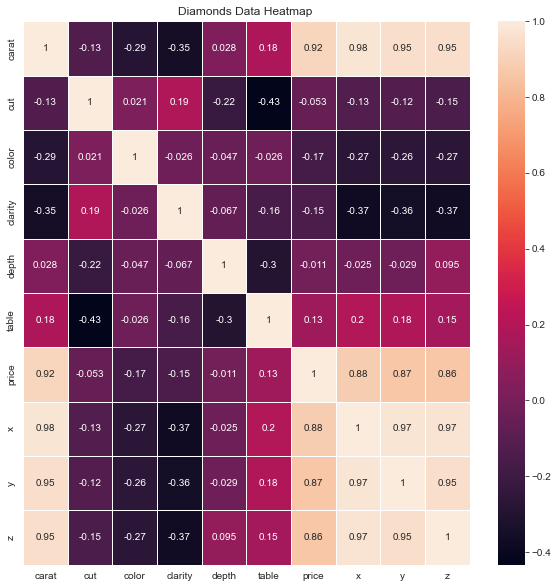

In [18]:
heat_map(data_df=diamonds_prep_df, data_name='Diamonds Data')

In the diamonds data Pearson Correlation heatmap, we see high correlation on carat,x, y, z and price columns. The pearson correlation values between price and carat is 0.92, x=0.88, y=0.87 and z=0.86. Carat seems to be the most important feature to tell the diamond price. The high correlation suggest carat, x, y, z values are the most predictive features for predicting the price of a diamond. The pearson correlation for these features are positive for target variable price. This means there is a positive relationship between these variables and price, hence the increasing any of these 4 features will lead the diamond price to be higher. These makes sense in the real world as well since the bigger diamonds (dimensions x,y,z) and/or carat (weight) are generally more expensive.


__Gas Data:__

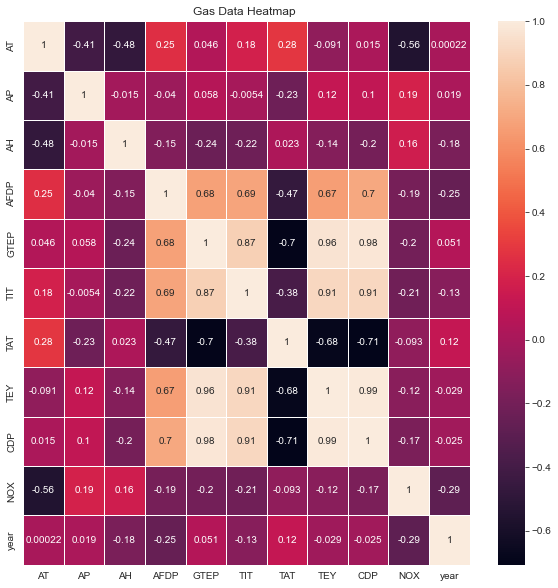

In [308]:
heat_map(data_df=gas_prep_df, data_name='Gas Data')

TODO explain

#### Question 3

Histogram of the numerical features for each dataset can be seen below:

In [309]:
def histogram_num_features(data, num_feats, data_name, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Numerical Features Histogram')
    for num_feat, ax_ind in zip(num_feats, ax.ravel()):
        sns.histplot(data, x=num_feat, ax=ax_ind)
        ax_ind.set_title(f'{num_feat} Histogram')
    plt.show()


##### __Diamond Dataset:__

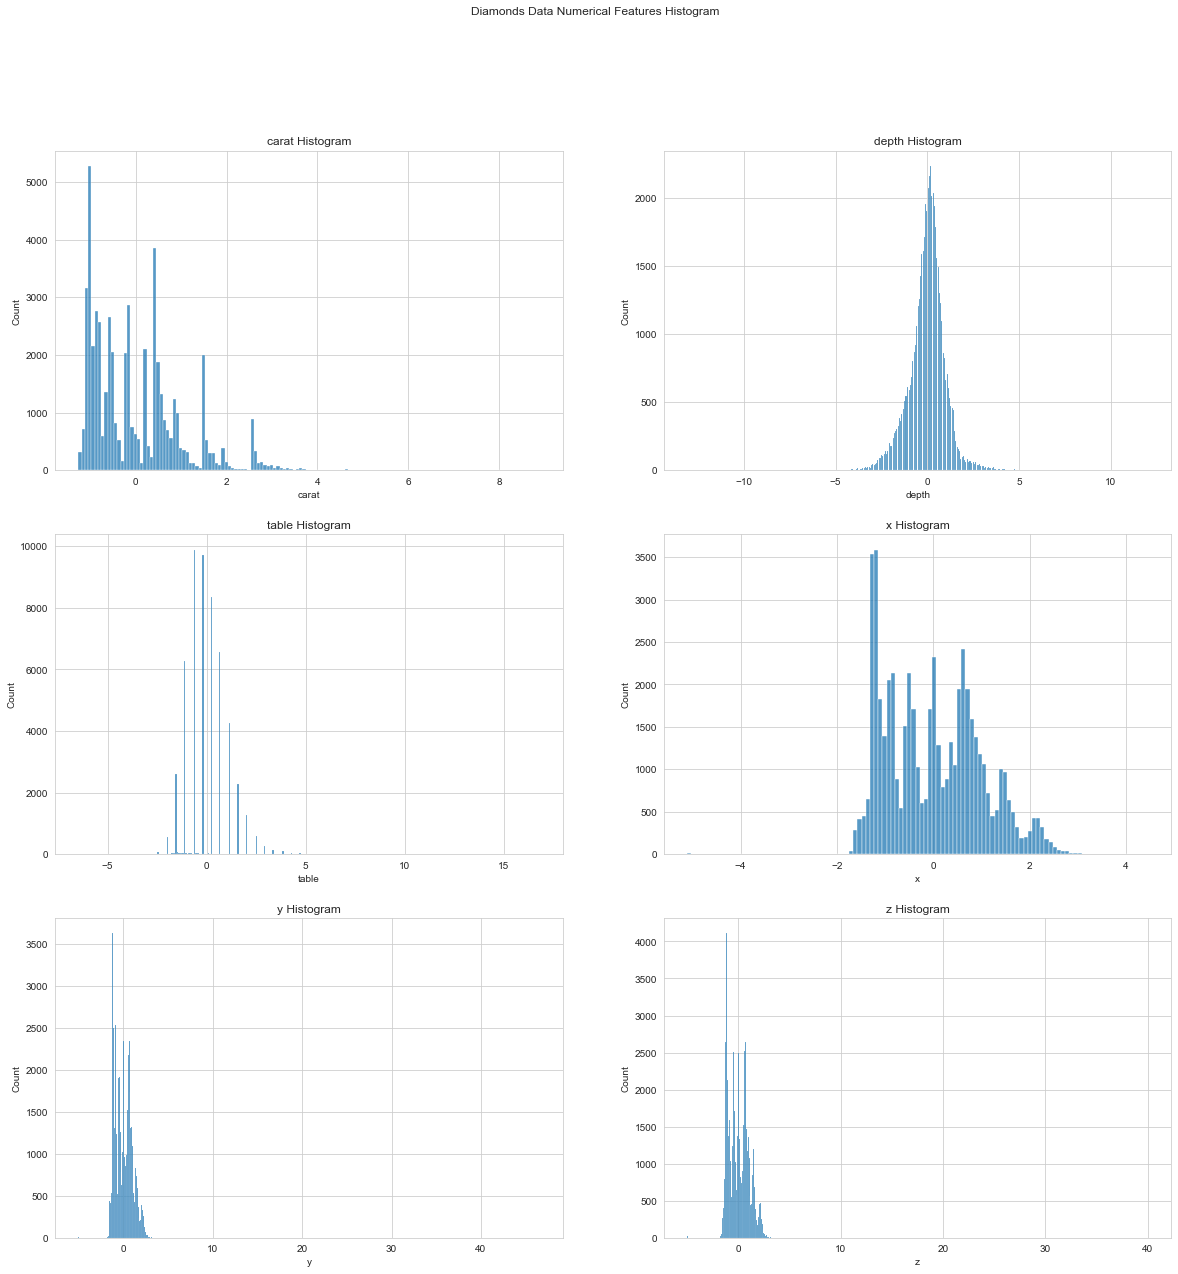

In [20]:
histogram_num_features(data=diamonds_prep_df,num_feats=diamonds_num_cols, data_name='Diamonds Data', 
                       num_rows=3, num_cols=2, fig_size=(20,20))

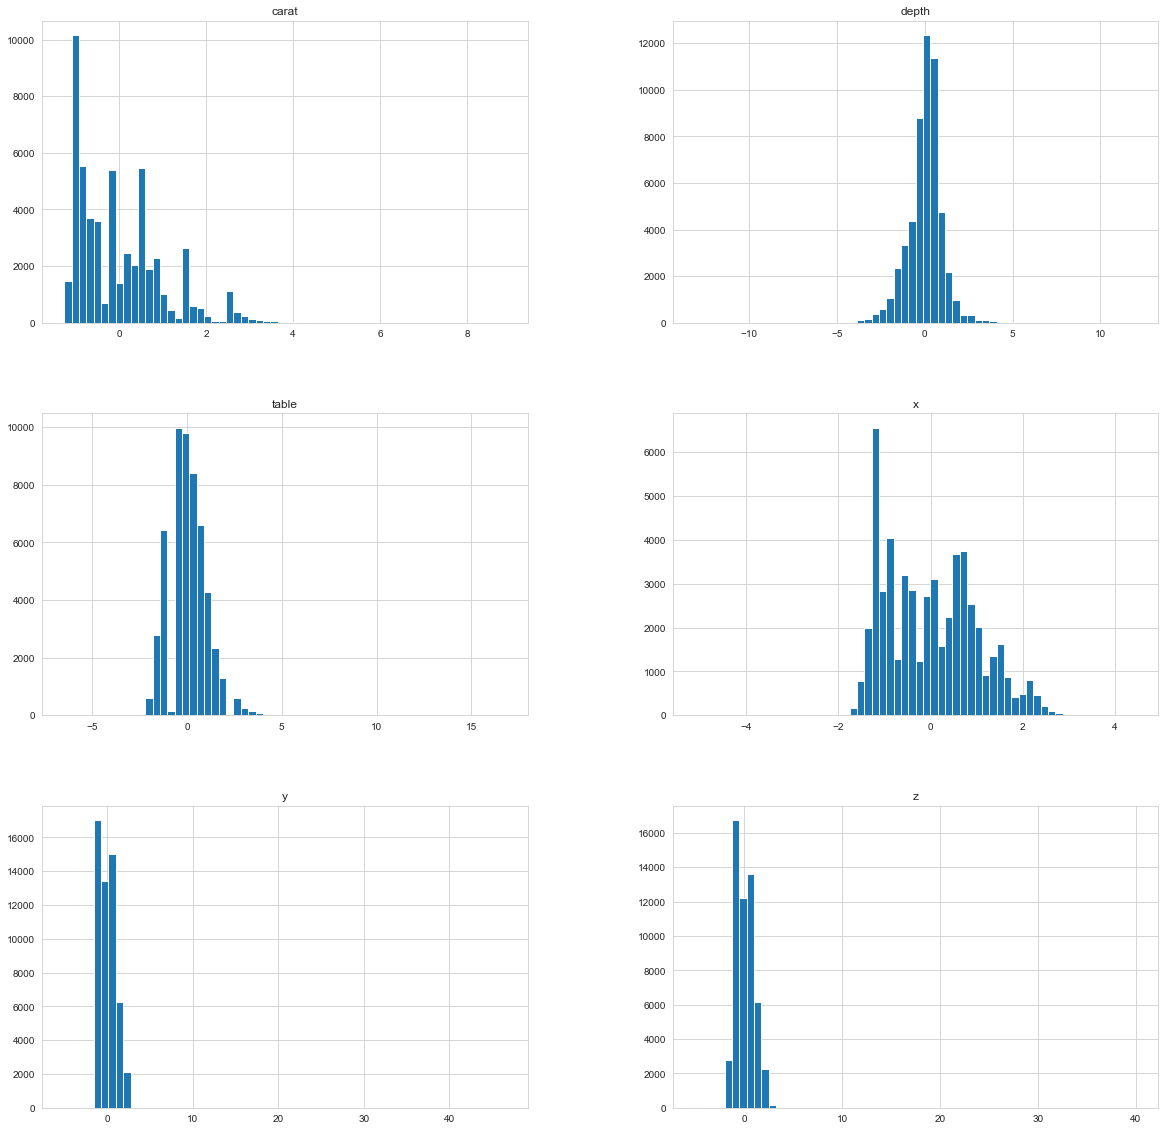

In [21]:
diamonds_prep_df[diamonds_num_cols].hist(figsize=(20, 20), bins=60)
plt.show()

In [22]:
diamonds_prep_df.describe()

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04  
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16  
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00  
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00  
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01  
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02  
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01  
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01

__Diamond Data:__

Carat and x features' histogram seems to be right skewed. Y and z plots have few outliers around 40 and they don't seem to follow gaussian distribution. Depth and table seems to be close to normal distribution.
 

##### __Gas Dataset:__

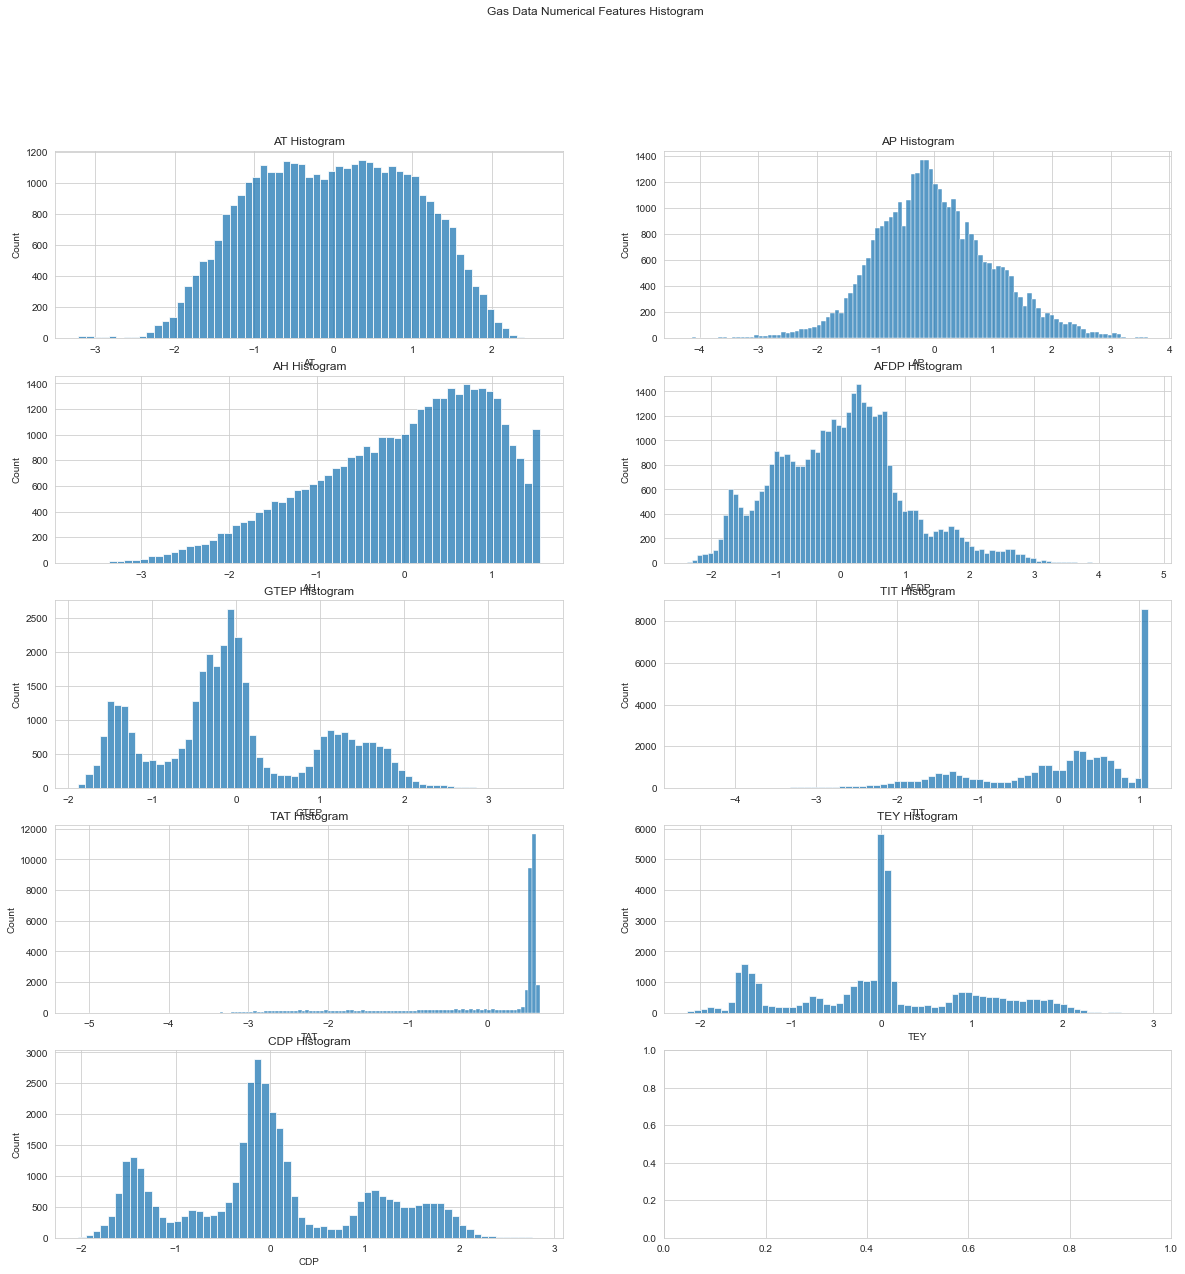

In [310]:
histogram_num_features(data=gas_prep_df,num_feats=gas_num_cols, data_name='Gas Data', 
                       num_rows=5, num_cols=2, fig_size=(20,20))

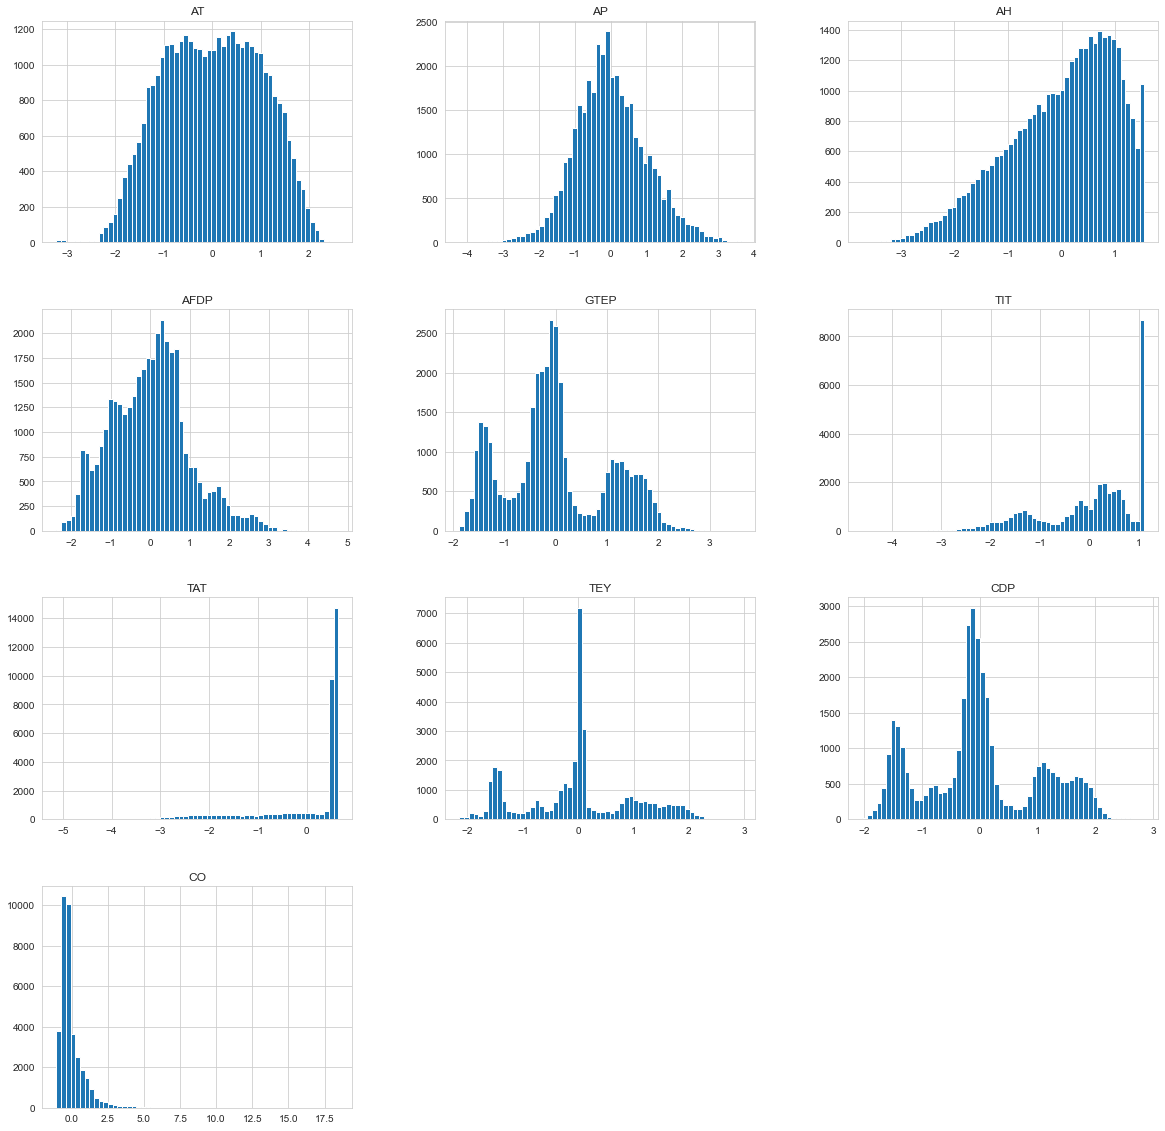

In [290]:
gas_prep_df[gas_num_cols].hist(figsize=(20, 20), bins=60)
plt.show()

In [311]:
gas_prep_df.describe()

AT            AP            AH          AFDP          GTEP  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean  -1.176081e-16 -1.233647e-14 -5.942306e-16 -1.015144e-15  5.230467e-16   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -3.215577e+00 -4.211524e+00 -3.719067e+00 -2.375059e+00 -1.874640e+00   
25%   -7.964882e-01 -6.606830e-01 -6.693112e-01 -7.363991e-01 -5.802810e-01   
50%    1.185304e-02 -7.274427e-02  1.799983e-01  1.574091e-02 -1.095835e-01   
75%    7.992472e-01  6.080269e-01  7.958550e-01  5.832377e-01  8.334799e-01   
max    2.603647e+00  3.640553e+00  1.544343e+00  4.761549e+00  3.611191e+00   

                TIT           TAT           TEY           CDP           NOX  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  36733.000000   
mean   9.609823e-15 -8.300659e-15  9.888369e-16 -4.673376e-16     65.293067   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00     11.678357   
min   -4.597825e+00 -5.132585e+00 -2.144032e+00 -2.028623e+00     25.905000   
25%   -5.490425e-01 -2.102398e-01 -5.798539e-01 -5.745191e-01     57.162000   
50%    2.550115e-01  5.438962e-01  1.431620e-02 -8.773591e-02     63.849000   
75%    8.879903e-01  5.672802e-01  6.769952e-01  7.296924e-01     71.548000   
max    1.110388e+00  6.505859e-01  2.944830e+00  2.845821e+00    119.910000   

               year  
count  3.673300e+04  
mean  -7.427883e-17  
std    1.000014e+00  
min   -1.399443e+00  
25%   -6.946951e-01  
50%    1.005331e-02  
75%    7.148017e-01  
max    1.419550e+00

__Gas Data:__

TODO reply. 

Carat and x features' histogram seems to be right skewed. Y and z plots have few outliers around 40 and they don't seem to follow gaussian distribution. Depth and table seems to be close to normal distribution.
 

__What preprocessing can be done if the distribution of a feature has high skewness?__

There are different ways to handle high skewed data and reduce its skewness:

1- Log Transform (natural log)   
2- Square root transform    
2- Box-Cox transformation   

There are different transformation possibilities to address the skewness of the data, and it is difficult to determine which one needs to be applied. This generally depends highly on the current doistribution of the data. Box-Cox transformation is a family of transformations where you select $\lambda$ value typically from -5 to 5. Optimal $\lambda$ is chosen based on the data where its transformation is the best approximation of a normally distributed curve. The transformation of data y is simply $y_\text{transformed} = y^\lambda$. 

 $\lambda=0$ corresponds to the natural log of the data.    
 $\lambda=0.5$ corresponds to the square root transform of the data.
 
 Hence, the first two approach is also contained within the Box-Cox transformation family.
 
 By applying Box-Cox Transformation one can decrese the high skewness and make the data distribution closer to normal distribution.

#### Question 4

Box plot of categorical features in each dataset against target variable. For each dataset I plotted two boxplots one with fliers and the other one without fliers (showfliers=False to not show outliers). I added the plots without fliers as I noticed that there are extreme values that stretch the plots too much and makes the boxplots compact, by not showing outliers, I can zoom in the boxplot itself to visually better see the differences between category values. 

In [324]:
def boxplot_cat_features(data, cat_feats, target_feature, categs_order, data_name, num_rows, num_cols, fig_size, showfliers=True):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Categorical Features Boxplot against target variable ({target_feature})')
    if num_rows == 1 and num_cols==1:
        ax_s = [ax]
    else:
        ax_s = ax.ravel()
    for cat_feat, ax_ind, cat_order in zip(cat_feats, ax_s, categs_order):
        sns.boxplot(data=data, x=cat_feat, y=target_feature,  ax=ax_ind, order=cat_order, showfliers=showfliers)
    plt.show()

##### __Diamonds Data:__

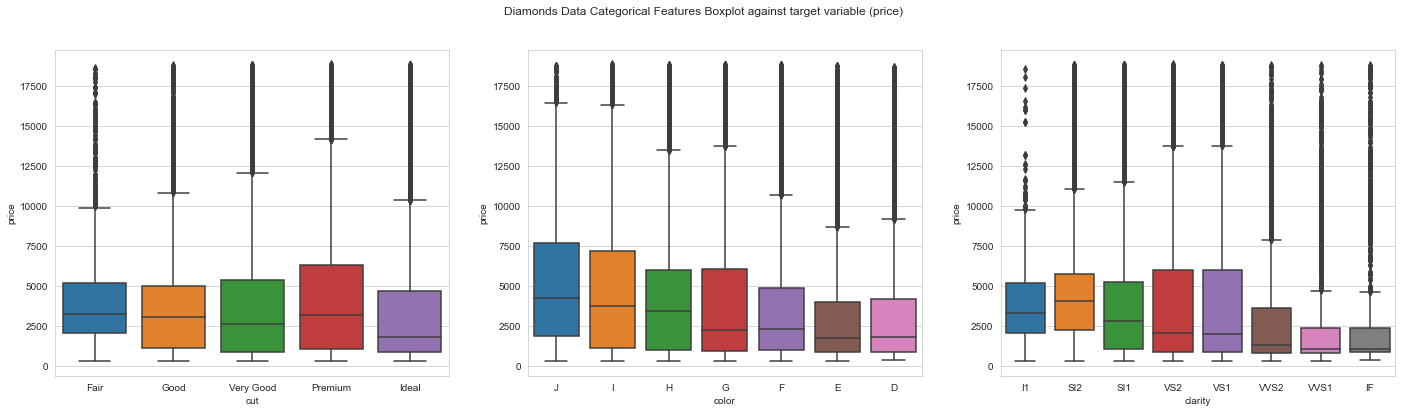

In [325]:
boxplot_cat_features(data=diamonds_df, cat_feats=diamonds_cat_cols, 
                     categs_order= diamonds_categs_order,
                     target_feature='price', data_name='Diamonds Data',
                     num_rows=1, num_cols=3, fig_size=(24,6))

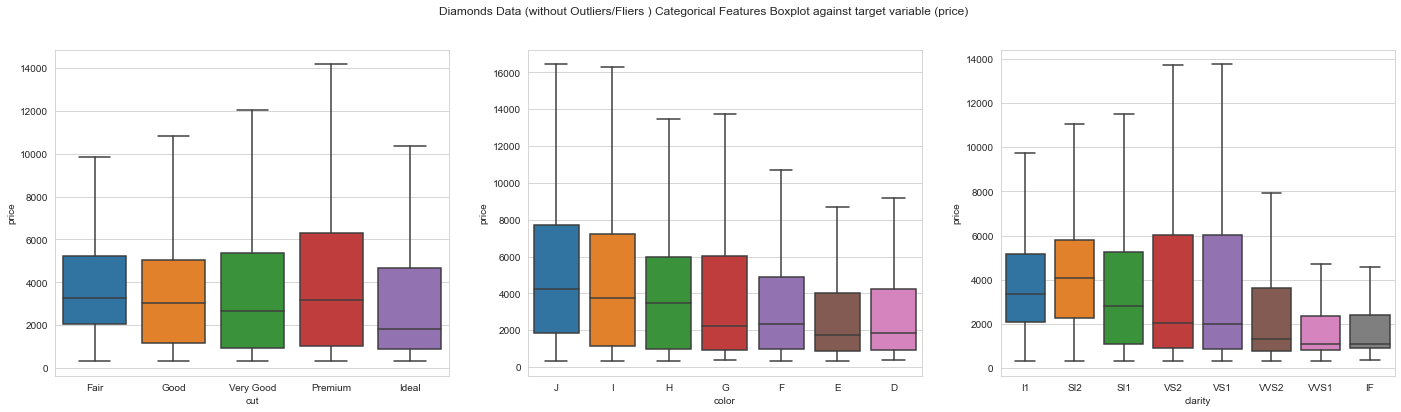

In [326]:
boxplot_cat_features(data=diamonds_df, cat_feats=diamonds_cat_cols, categs_order= diamonds_categs_order,
                     target_feature='price', data_name='Diamonds Data (without Outliers/Fliers )',
                     num_rows=1, num_cols=3, fig_size=(24,6), showfliers=False)

__Diamond Dataset:__

Cut boxplots: The minimum of the cut categories are all very close. The median values are close to each other except for the Ideal cut where the median price is lower compared to its counterparts. One surprising thing to see is that even though Ideal is the best quality, the median, 3rd percentile and maximum (Q3+1.5*IQR) prices are lower compared to Premium and Very Good cut categories. Premium cut has a higher  3rd percentile and maximum (Q3+1.5*IQR) values compared to other categories. All cuts have outlier prices that goes as high as around 17500. From the plot, we can say that the median and minimum price ranges are similar between cut types, but . 

Color boxplots: J color seems to have higher prices since its 1st quartile, median and 3rd quartile are higher than its counter parts. If we group colors by similar price distributions we can say that J,I pricing distribution are close to each other, with the highest price distributions and E,D is the colors where diamond prices are lower overall. Though outliers exists for all color types that has peak prices. For lower color quality the median and 3rd quartile prices are higher compared to the high quality colors.

Clarity boxplots: This is the variable that has most diverse price distributions on its categories. The highest median and minimum value price belongs to SI2. VS2 and VS1 distiributions looks like very similar, these two types of clarity seems to have a lower median but highest 3rd quartile compared to other clarity levels. Best clarity level IF, price distribution is more compact toward lower price ranges. Again all categories have many outliers. 



##### __Gas Data:__

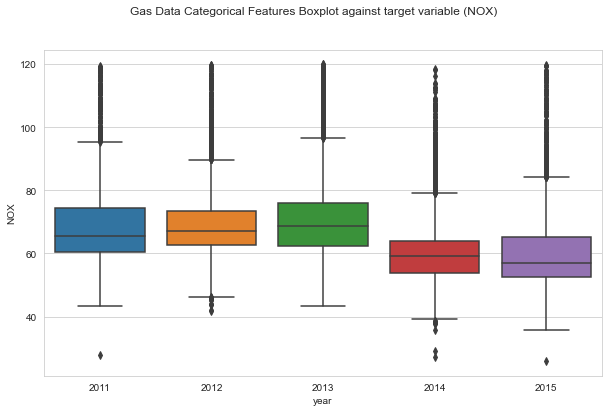

In [329]:
boxplot_cat_features(data=gas_df, cat_feats=gas_cat_cols,  categs_order= [year_categories],
                     target_feature='NOX', data_name='Gas Data',
                     num_rows=1, num_cols=1, fig_size=(10,6))

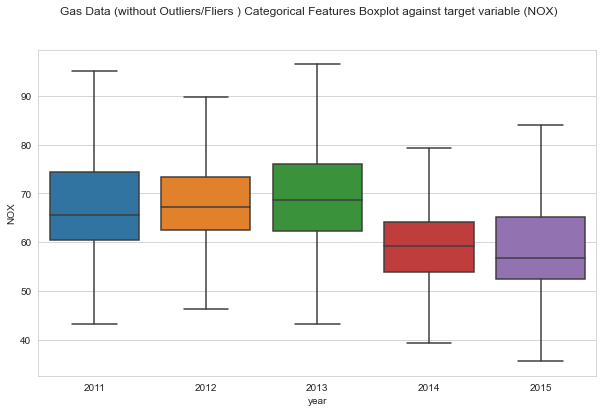

In [330]:
boxplot_cat_features(data=gas_df, cat_feats=gas_cat_cols,  categs_order= [year_categories],
                     target_feature='NOX', data_name='Gas Data (without Outliers/Fliers )',
                     num_rows=1, num_cols=1, fig_size=(10,6), showfliers=False)

TODO answer q

__GasDataset:__

year boxplots: ** to do Answer ** 

The minimum of the cut categories are all very close. The median values are close to each other except for the Ideal cut where the median price is lower compared to its counterparts. One surprising thing to see is that even though Ideal is the best quality, the median, 3rd percentile and maximum (Q3+1.5*IQR) prices are lower compared to Premium and Very Good cut categories. Premium cut has a higher  3rd percentile and maximum (Q3+1.5*IQR) values compared to other categories. All cuts have outlier prices that goes as high as around 17500. From the plot, we can say that the median and minimum price ranges are similar between cut types, but . 



#### Question 5

In [26]:
def countplot_cat_features(data, num_feats, data_name,diamonds_categs_order, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Count plots')
    for num_feat, cat_order, ax_ind in zip(num_feats, diamonds_categs_order, ax.ravel()):
        sns.countplot(data=data, x=num_feat,  ax=ax_ind, order=cat_order)
    plt.show()

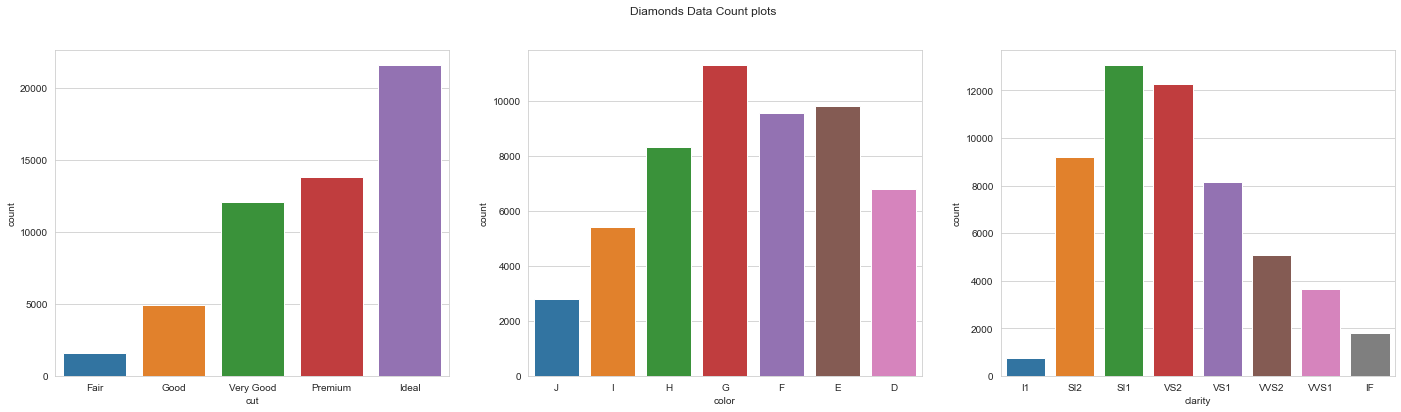

In [27]:
countplot_cat_features(data=diamonds_df, num_feats=diamonds_cat_cols, 
                     data_name='Diamonds Data', diamonds_categs_order=diamonds_categs_order,
                     num_rows=1, num_cols=3, fig_size=(24,6))

__In the diamonds data:__

Cut categories is not equally distributed in the data, ideal cut has the largest sample size. Actually cut quality vs sample size for that cut has positive relationship. Better quality cuts have more samples in the dataset.

Color categories are better distributed in the dataset compared to cut, but still not equally distributed per se. J has the lowest sample count in the dataset whereas G has the highest. Looks like the majority of the data has medium level quality colors.

Clarity variable for the data is uneven as well. The majority of the samples in the dataset lies within SI2, SI1 and VS2 categories (low-medium quality). There are fewer samples for the worst and best clarity diamonds. 

#### Question 6

In [ ]:
# todo later

#### Feature Selection

For this part Mutual Info Regressiong and F regression is used from sklearn library for both datasets. For each preprocessed feature I computed the mutual info and f regression values against target variable.

##### __Question 7__

Mutual Info (MI) Regression calculates the dependency between two vairables and it should be a nonnegative value. 0 means two variables are independent from each other, higher MI values corresponds to higher dependency between the variables. 

F Regreesion performs univariate linear regression tests to capture the relationship between the given variables.

##### __Diamonds Data__

__Diamonds Data Mutual Info Regression & F Regression__

In [28]:
diamond_features = list(diamonds_num_cols)+list(diamonds_cat_cols)
X_diamonds = diamonds_prep_df[diamond_features]
X_diamonds_unscaled = diamonds_unscaled_df[diamond_features]
y_diamonds = diamonds_prep_df['price']

In [29]:
# mi regression
mi = mutual_info_regression(X_diamonds, y_diamonds)
mi_scaled = mi / np.max(mi)

# f regression
f_test, _ = f_regression(X_diamonds, y_diamonds)
f_test_scaled = f_test / np.max(f_test)

res_df = pd.DataFrame([diamond_features, mi, mi_scaled, f_test, f_test_scaled ]).T
res_df.rename(columns={0:'Feature Name', 1:'Mutual Info Regression Score',2:'Mutual Info Regression Score - Scaled',
                       3:'F Regression Score',4:'F Regression Score - Scaled'}, inplace=True)
res_df.sort_values(by='Mutual Info Regression Score - Scaled', ascending=False, inplace=True)
res_df

Feature Name Mutual Info Regression Score  \
0        carat                      1.65247   
4            y                      1.42218   
3            x                      1.41241   
5            z                      1.36035   
8      clarity                     0.217059   
7        color                     0.137524   
6          cut                    0.0600886   
2        table                    0.0329356   
1        depth                    0.0301225   

  Mutual Info Regression Score - Scaled F Regression Score  \
0                                     1             304051   
4                              0.860636             160916   
3                              0.854726             193742   
5                              0.823219             154923   
8                              0.131354            1188.01   
7                             0.0832233             1654.4   
6                             0.0363628            154.784   
2                             0.0199311            886.119   
1                             0.0182287            6.11586   

  F Regression Score - Scaled  
0                           1  
4                    0.529238  
3                      0.6372  
5                     0.50953  
8                  0.00390726  
7                  0.00544119  
6                 0.000509073  
2                  0.00291437  
1                 2.01146e-05

Table above shows the mutual info and f regression reasult for each variable against target variable price. Table is ordered by Mutual Info Regression Score - Scaled column. 

__Diamonds Data Scatter Plot of features vs target variable along with Scaled Mutual Info and F Regression Scores__

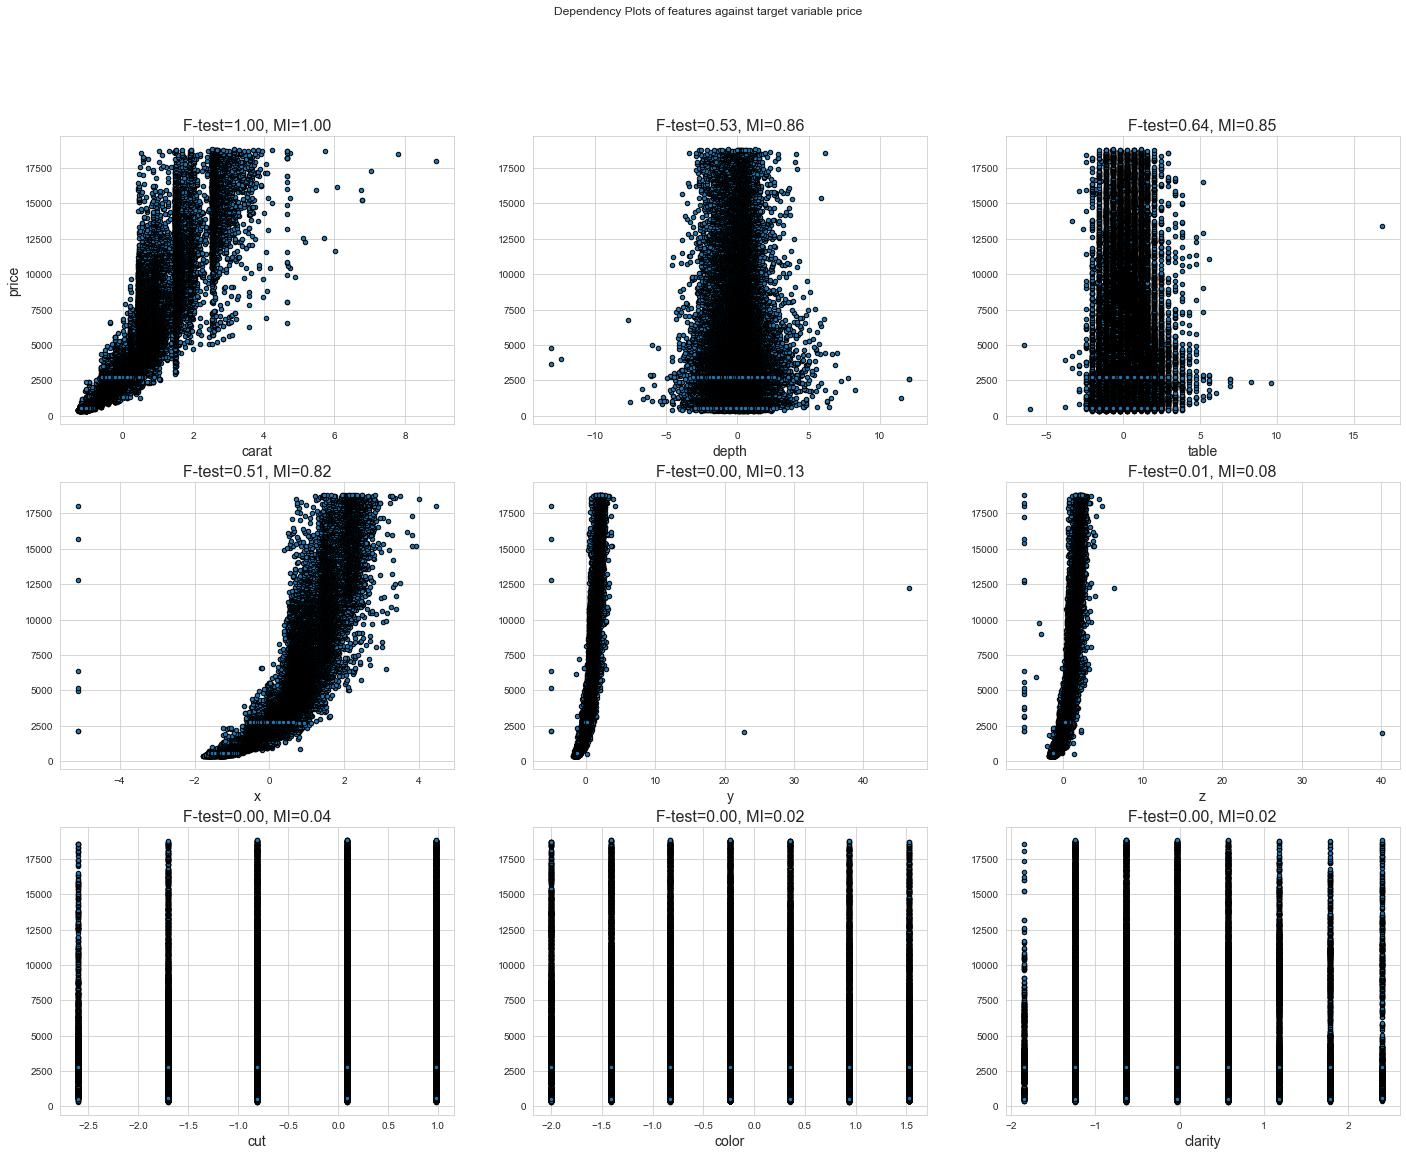

In [30]:
target_name ='price'
plt.figure(figsize=(24, 18))
plt.suptitle(f'Dependency Plots of features against target variable {target_name}')
for i, feat in enumerate(diamond_features):
    plt.subplot(3, 3, i + 1)
    plt.scatter(X_diamonds[feat], y_diamonds, edgecolor="black", s=20)
    plt.xlabel(feat, fontsize=14)
    if i == 0:
        plt.ylabel(target_name, fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(res_df['F Regression Score - Scaled'].iloc[i], res_df['Mutual Info Regression Score - Scaled'].iloc[i]), fontsize=16)
plt.show()

__Diamonds Data Most important Features:__

Mutual Info Regression most important 4 features:  carat, y, x, z.

F Regression most important 4 features: carat, x, y, z.

The order between mutual info and f regression for feature importances are slightly different.

I also experimented on different feature sets with Linear Regression model to see how their performance would change. All features in the diamond dataset seems to be helping for prediction since subset of the features perform worse with Linear Regression model. Given that diamonds dataset has very few variables, I decided to keep all of them and skip the feature selection part. In addition to this the experiments done on Q11 supports this decision, with the OLS experiment some results with other linear packages show that all features are important with p value being less than 0.05. You can refer to Q11 explanation for more details on this.

In [31]:
def apply_cv_to_model(model, X, y, model_name, cv=10, scoring= 'neg_root_mean_squared_error', print_res=True):
    cv_results = cross_validate(model, X,y,
                                    scoring=scoring, cv=cv, 
                                    return_train_score=True,return_estimator=True)
    train_rmse = cv_results['train_score']*(-1.)
    test_rmse = cv_results['test_score']*(-1.)
    if print_res:
        print(f'{model_name} Train Avg RMSE accross 10-fold cv: ', train_rmse.mean())
        print(f'{model_name} Validation Avg RMSE accross 10-fold cv: ',test_rmse.mean())
    return cv_results 

In [32]:
feat_sets = [ ('All Features', X_diamonds.columns.tolist()),
             ('Top 6 Features', ['carat','x','y','z','clarity','color']),
             ('Top 4 Features', ['carat','x','y','z'])
]

for f_name, feat_set in feat_sets:
    print(f'\n\n10-fold CV Linear Regression Experiment with {f_name}: \n Features:{feat_set}')
    model_lr = LinearRegression()
    important_feats_diamonds = ['carat','x','y','z','clarity','color']
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_diamonds[feat_set], y=y_diamonds, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)

for name, fs in [('Mutual Info Regr.',mutual_info_regression),  ('F Regr.',f_regression)]:
    top_feats = 5
    print(f'\n\nTop {top_feats} {name} features:')
    X_new = SelectKBest(fs, k=top_feats).fit_transform(X_diamonds, y_diamonds)

    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_new, y=y_diamonds, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)



10-fold CV Linear Regression Experiment with All Features: 
 Features:['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.280596794617
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850985


10-fold CV Linear Regression Experiment with Top 6 Features: 
 Features:['carat', 'x', 'y', 'z', 'clarity', 'color']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1221.6042206336504
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1228.2203041711414


10-fold CV Linear Regression Experiment with Top 4 Features: 
 Features:['carat', 'x', 'y', 'z']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1512.5608891324323
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1405.0166387786403


Top 5 Mutual Info Regr. features:
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1327.377219542444
Linear Regression (OLS) Validation Avg 

##### __Gas Data__

__Gas Data Mutual Info Regression & F Regression__

In [331]:
gas_features = list(gas_num_cols)+list(gas_cat_cols)
X_gas = gas_prep_df[gas_features]
X_gas_unscaled = gas_unscaled_df[gas_features]
y_gas = diamonds_prep_df['NOX']

In [333]:
# mi regression
mi = mutual_info_regression(X_gas, y_gas)
mi_scaled = mi / np.max(mi)

# f regression
f_test, _ = f_regression(X_gas, y_gas)
f_test_scaled = f_test / np.max(f_test)

res_df = pd.DataFrame([gas_features, mi, mi_scaled, f_test, f_test_scaled ]).T
res_df.rename(columns={0:'Feature Name', 1:'Mutual Info Regression Score',2:'Mutual Info Regression Score - Scaled',
                       3:'F Regression Score',4:'F Regression Score - Scaled'}, inplace=True)
res_df.sort_values(by='Mutual Info Regression Score - Scaled', ascending=False, inplace=True)
res_df

Feature Name Mutual Info Regression Score  \
5          TIT                     0.279721   
7          TEY                     0.274431   
0           AT                     0.268504   
4         GTEP                     0.249459   
8          CDP                     0.232809   
3         AFDP                     0.143041   
9         year                     0.141031   
6          TAT                     0.120372   
1           AP                    0.0960705   
2           AH                    0.0430093   

  Mutual Info Regression Score - Scaled F Regression Score  \
5                                     1            1760.54   
7                              0.981089            502.111   
0                              0.959901            16622.8   
4                              0.891814            1556.57   
8                              0.832292            1109.82   
3                               0.51137            1349.46   
9                              0.504185            3421.69   
6                              0.430329             319.01   
1                              0.343451            1404.93   
2                              0.153758            1023.09   

  F Regression Score - Scaled  
5                    0.105911  
7                   0.0302062  
0                           1  
4                   0.0936405  
8                   0.0667649  
3                   0.0811813  
9                    0.205844  
6                   0.0191911  
1                   0.0845184  
2                   0.0615477

Table above shows the mutual info and f regression reasult for each variable against target variable NOX. Table is ordered by Mutual Info Regression Score - Scaled column. TIT, TEY, AT, GTEP and CDP seems to be the most important features for Mutual Info Regression. For F Regression the most important feature seems to be AT.

__Gas Data Scatter Plot of features vs target variable along with Scaled Mutual Info and F Regression Scores__

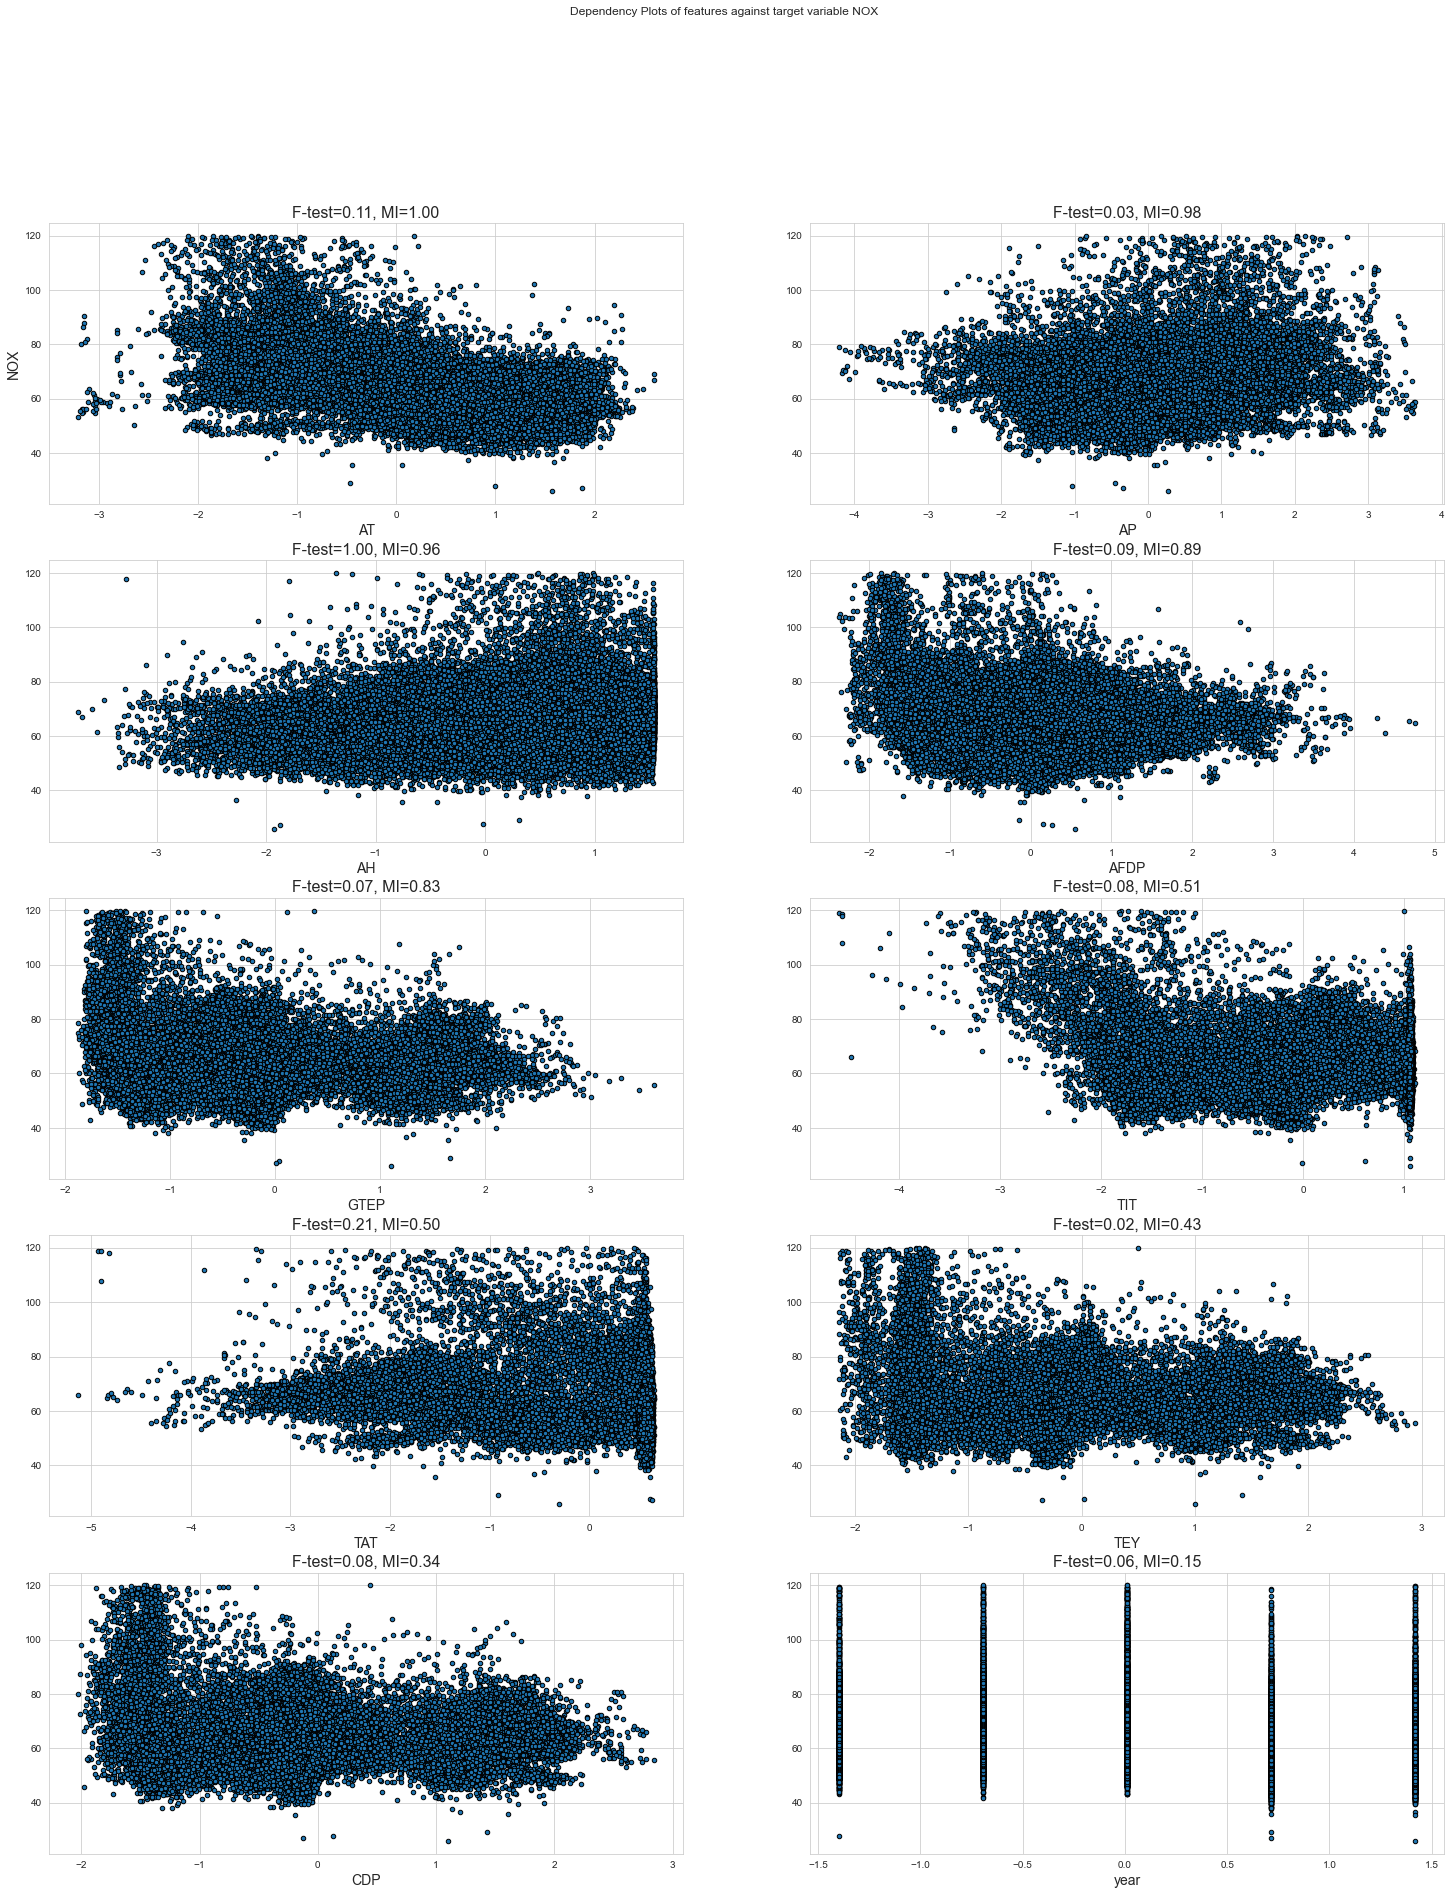

In [339]:
target_name ='NOX'
plt.figure(figsize=(25, 30))
plt.suptitle(f'Dependency Plots of features against target variable {target_name}')
for i, feat in enumerate(gas_features):
    plt.subplot(5, 2, i + 1)
    plt.scatter(X_gas[feat], y_gas, edgecolor="black", s=20)
    plt.xlabel(feat, fontsize=14)
    if i == 0:
        plt.ylabel(target_name, fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(res_df['F Regression Score - Scaled'].iloc[i], res_df['Mutual Info Regression Score - Scaled'].iloc[i]), fontsize=16)
plt.show()

__Gas Data Most important Features:__

Mutual Info Regression most important 5 features:  TIT, TEY, AT, GTEP and CDP 
F Regression most important 4 features: AT, year, TIT.

Important features found by mutual info and f regression are different.

I also experimented on different feature sets with Linear Regression model to see how their performance would change. All features in the RMSE dataset seems to be helping for prediction since subset of the features perform worse with Linear Regression model. So, I will use all the features in the dataset.

TODO decide to select variables? 

In [340]:
feat_sets = [ ('All Features', X_gas.columns.tolist()),
             ('Top MI Reg. Features', ['TIT','TEY','AT','GTEP','CDP']),
             ('Top F Reg. Features', ['AT','year','TIT'])
]

for f_name, feat_set in feat_sets:
    print(f'\n\n10-fold CV Linear Regression Experiment with {f_name}: \n Features:{feat_set}')
    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_gas[feat_set], y=y_gas, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)

for name, fs in [('Mutual Info Regr.', mutual_info_regression),  ('F Regr.',f_regression)]:
    top_feats = 5
    print(f'\n\nTop {top_feats} {name} features:')
    X_new = SelectKBest(fs, k=top_feats).fit_transform(X_gas, y_gas)

    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_new, y=y_gas, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)



10-fold CV Linear Regression Experiment with All Features: 
 Features:['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'year']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.030473106723004
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.881846484410762


10-fold CV Linear Regression Experiment with Top MI Reg. Features: 
 Features:['TIT', 'TEY', 'AT', 'GTEP', 'CDP']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  9.14421286309772
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  9.455365986158789


10-fold CV Linear Regression Experiment with Top F Reg. Features: 
 Features:['AT', 'year', 'TIT']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.870111551541857
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  9.278648847152846


Top 5 Mutual Info Regr. features:
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  9.14421286309772
Linear Regression (OLS) Validation Avg RMSE a

__How does this step affect the performance of your models in terms of test RMSE?__

Feature selection has different effects on the performance of the test data. If the removed features contains redundant data, noise or unrelated to the target variable, this step reduces the chances for overfitting, enhance the model generalization and improves the test RMSE score. This means if features selected precisely, test RMSE score is expected to lower and model to perform better. However, if deleted features contain important information that can be used for the prediction, the test RMSE score would increase and model performing worse. That is why, feature selection is a not a trivial step and should be performed carefully on which data we want to keep and remove. Feature selection also help decreasing both training and inference time given that we have to deal with less data. 

If we think specifically for feature selection based on mutual information, it is not only limited to linear dependency but it rather quantifies the amount of information obtained from observing one variable about the other one. Whereas f regression captures only linear relationship between variables. Ideally, both feature selection methods expect to decrease redundant variables which leads less opportunity to overfit the model and better generalization. This means we expect to have good performing models with lower RMSE test scores. However, again we need to be careful, for example, with f regression we might possibly discard important nonlinear features during feature selection. This might hurt the model performance and increase the test RMSE score.
To conclude, feature selection is a step to help reducing overfitting and to have generalization, improving both performance and time to train and inference of the model and leads to lower test RMSE score if performed successfully.




## Linear Regression

#### Question 8

__What is the objective function?__

The Linear Regression model prediction is made:
$$ \hat{y} = b + \sum_{i=1}^{p} x_iw_i =  x^Tw $$

$\hat{y}$ is predicted value, b bias (intercept term), p is the number for features, w is weights and x is the input data.
(In the second part of the equation b is incorparated in the w in this case.).

Using RMSE as our error metric:

__Ordinary Least Squares (Linear Regression without Regularization) Objective Function:__

$ \min_{w} ||(Xw - Y)||^2_2 $

__Lasso Regression (L1 Regularization) Objective Function:__

$ \min_{w} ||(Xw - Y)||^2_2  + \lambda ||w||_1$


__Ridge Regression (L2 Regularization) Objective Function:__

$\min_{w} ||(Xw - Y)||^2_2  + \lambda ||w||^2_2$

X input, Y ground truth label, w parameters and $\lambda$ is the regularization strength, hyperparameter to be tuned.

__Explain how each regularization scheme affects the learned hypotheses.__ 

Regularization techniques are used to avoid model overfitting and improving model generalization by adding a penalty term to the objective function. The intuition behind regularization is that by adding penalty terms related to the model weights (coefficients), the optimizer won't try to increase some weights larger and larger, so it encourages the weights to be kept small.

- __Lasso Regression:__

Lasso is also called L1 Regularization, it adds the absolute value of magnitude of coefficients  (L1 norm) as penalty term to the loss function. It's advantage is it can set some coefficients to 0 (create sparse solutions), hence it might eliminate some features and can be considered as a built-in feature selection. It has unstable solution and may have  multiple solutions for the optimization problem. 


- __Ridge Regression:__

Ridge also called as L2 regularization since it adds squared magnitude of coefficients (squared L2 norm) as penalty term to the loss function. It forces the coefficients to be lower, close to 0 but not 0. The output is therefore non-sparse and it doesn't choose some subset of the features. It is computationally efficient since it has analytical solutions. After L2 regularization the optimal solutions are generally more stable.


#### Question 9

For each model I applied 10-fold cross-validation and measured average RMSE errors for training and validation sets.

__How to pick optimal penalty (lambda) parameter? (alpha in sklearn)__

There are several ways to select best values for choosing optimal regaularization value for linear models:

1- Via cross validation and grid search    
2- Using information criterion (AIC, BIC) for Lasso Regression     
3- Using model specific cross validations implemented in sklearn such as LassoCV and RidgeCV.   

Lasso and Ridge models also have their own special cross validation implementations in scikit-learn to find a good value of penalty scores. They are called LassoCV and RidgeCV model, but the scores are calculated in terms of MSE rather than RMSE and only test scores are returned. Given that we are also interested on the training scores for the questions, I could't use these functions. 

For Lasso Regression you can see the results of different lambda (alpha in sklearn) parameters both with Cross Validation + GridSearch and with AIC, BIC method. For Ridge Regression alpha value is only done with 10-fold cross validation over gridsearch with different lambda (alpha in sklearn) values.

Note: For cross validation results, sklearn scoring function uses negative RMSE values (neg_root_mean_squared_error) to be able to minimize the loss function. That is why the returned RMSE values are negative and we can simply get their absolute results as the RMSE value.

##### Diamonds Data Resulta

###### __Ordinary Least Squares (Linear Regression without Regularization)__

In [33]:
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='Linear Regression (OLS)',
                                  cv=10)

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.280596794617
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850985


Check RMSE results for each of the 10-fold:

In [34]:
print('Train RMSEs:', cv_results_lr['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr['test_score']*(-1.))

Train RMSEs: [1246.67693953 1248.66216822 1230.78437231 1190.65068211  954.23438537
 1157.68140298 1256.25260037 1252.99820555 1264.05281144 1260.81240006]
Validation RMSEs:  [ 942.74216047  918.48055067 1112.58133725 1480.56810359 2806.51518647
 1699.75830566  815.69881421  877.61209435  670.86071043  725.63324541]


###### __Lasso Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [35]:
def linear_model_exp(X,y):
    full_pipeline = Pipeline([('model', "passthrough")
                             ])
    alphas = [10**(x) for x in range(-8,6)]
    params = {
        "model": [Ridge(random_state=rand_seed),
                  Lasso(random_state=rand_seed)
               ],
        "model__alpha": alphas
    }

    t0 = time.time()
    grid_search = GridSearchCV(full_pipeline, params, cv=10, 
                               scoring='neg_root_mean_squared_error', 
                               return_train_score=True)
    cv_results = grid_search.fit(X, y)
    t1 = time.time()
    elapsed = t1-t0
    #print(time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
    grid_results_df = pd.DataFrame(grid_search.cv_results_)
    grid_results_df['model_name']= grid_results_df.param_model.apply(lambda x: 'Ridge' if type(x)==Ridge else 'Lasso')
    grid_results_df['mean_train_score'] = grid_results_df['mean_train_score']*-1
    grid_results_df['mean_test_score'] = grid_results_df['mean_test_score']*-1
    grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
    #grid_results_df.head()
    return grid_search, grid_results_df

In [36]:
grid_search_lr, grid_res_lr_df = linear_model_exp(X=X_diamonds, y=y_diamonds)

In [37]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df[grid_res_lr_df.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14       1206.280597            1205.045051      Lasso              1e-08
15       1206.280597            1205.045051      Lasso              1e-07
16       1206.280597            1205.045052      Lasso              1e-06
17       1206.280597            1205.045064      Lasso              1e-05
18       1206.280597            1205.045161      Lasso             0.0001
19       1206.280597            1205.046257      Lasso              0.001
20       1206.280605            1205.057629      Lasso               0.01
21       1206.281434            1205.175550      Lasso                0.1
22       1206.357387            1206.498138      Lasso                  1
23       1210.657916            1225.290602      Lasso                 10
24       1251.275772            1244.896044      Lasso                100
25       1843.911711            1770.022846      Lasso               1000
26       3957.162324            3544.036398      Lasso              10000
27       3957.162324            3544.036398      Lasso             100000

The best average train and validation RMSE scores for Lasso Regression are in the 1205-1206 ranges. A good range for alpha is in this case is around 0.01 and 1. Since the RMSE doesn't change too much, we can pick 1 as the optimal penalty parameter. The reason behind is that we want to have simpler model that could achieve a good performance. Having a higher regularization helps us having simpler model and we can see that with $\alpha=1$ we can achieve average RMSE results very close to the ones we found in the case of no regularization both in training and validation sets.   

###### __Penalty Selection based on AIC/BIC for Lasso__

Lasso model fit with Lars using BIC (Bayes Information criterion) or AIC (Akaike information criterion) for model selection. 
These two criterion are used to select the regularization parameter. A good model should explain well the data while being simple to achieve that a trade-off between the goodness of fit and the complexity of the model is made.

In [38]:
lasso_lars_ic =  LassoLarsIC(criterion="aic", normalize=False).fit(X=X_diamonds, y=y_diamonds)
results = pd.DataFrame({"alphas": lasso_lars_ic.alphas_,
                        "AIC criterion": lasso_lars_ic.criterion_,}).set_index("alphas")
alpha_aic = lasso_lars_ic.alpha_
lasso_lars_ic.set_params(criterion="bic").fit(X_diamonds, y_diamonds)
results["BIC criterion"] = lasso_lars_ic.criterion_
alpha_bic = lasso_lars_ic.alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

In [39]:
def plot_aic_bic(alpha_aic, alpha_bic, results):
    ax = results.plot(figsize=(8,7))
    ax.vlines(
        alpha_aic,
        results["AIC criterion"].min(),
        results["AIC criterion"].max(),
        label="alpha: AIC estimate",
        linestyles="--",
        color="tab:blue",
    )
    ax.vlines(
        alpha_bic,
        results["BIC criterion"].min(),
        results["BIC criterion"].max(),
        label="alpha: BIC estimate",
        linestyle="--",
        color="tab:orange",
    )
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("criterion")
    ax.set_xscale("log")
    ax.legend()
    _ = ax.set_title(
        f"Information-criterion for model selection)"
    )

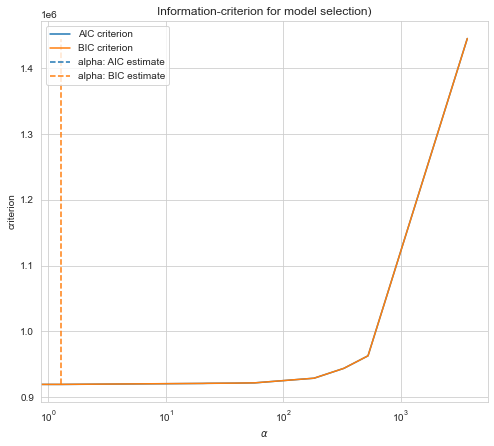

In [40]:
plot_aic_bic(alpha_aic=alpha_aic, alpha_bic=alpha_bic, results=results)

According to AIC criterion good alpha value is 0, and BIC criterion is around 1.3. This also supports the result we found above.

###### __Ridge Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [41]:
grid_res_lr_df[grid_res_lr_df.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
2        1206.280597            1205.045051      Ridge              1e-06
3        1206.280597            1205.045052      Ridge              1e-05
4        1206.280597            1205.045059      Ridge             0.0001
5        1206.280597            1205.045137      Ridge              0.001
6        1206.280597            1205.045909      Ridge               0.01
7        1206.280598            1205.053637      Ridge                0.1
8        1206.280754            1205.131037      Ridge                  1
9        1206.295931            1205.916546      Ridge                 10
10       1207.536689            1214.414691      Ridge                100
11       1248.699264            1292.818122      Ridge               1000
12       1458.983908            1489.476610      Ridge              10000
13       2112.850610            1950.711595      Ridge             100000

In the case of Rigde regression we can increase the regularization in the range of 1-10. With the similar reasoning explained for Lasso, I will pick 10 as the optimal parameter. 

###### __Best Regularization with optimal penalty parameter__

In the diamonds dataset, both Lasso and Ridge Regularization reach the same optimal results for average RMSE on training and validation sets. These results are also same for Linear Regression without regularization and lies in within 1205-1206 RMSE score. If we only look at the average optimal results, these 3 models don't really have much difference. When I checked the std of the train and validation RMSE scores for 10-fold cv(shown below) and the scores for each fold individually, again there is nothing very different for Lasso and Ridge Regression.

If I choose one, I would pick Ridge regularization since it seems to be better regularization scheme for diamonds data for the overall RMSE scores for higher regularization values. The avg. scores are way lower in Ridge then Lasso. For example Lasso when alpha=1000 avg RMSE validation score=1770 and Ridge when alpha=1000 avg RMSE validation score=1292. Therefore, Ridge regularization is best regularization scheme with optimal penalty 1.

Ridge Regression Results (test score columns are actually validation score here, crossvalidate names them as test.)

In [42]:
model = 'Ridge'
val_cols = [c for c in grid_res_lr_df.columns if 'test' in c or 'validation' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][val_cols])

tr_cols = [c for c in grid_res_lr_df.columns if 'train' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][tr_cols])

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
8        -943.047423        -918.745592       -1112.593318       -1480.207682   
9        -945.772298        -921.113590       -1112.713075       -1476.998752   

   split4_test_score  split5_test_score  split6_test_score  split7_test_score  \
8       -2806.756166       -1700.057234        -815.570266        -877.496956   
9       -2809.011538       -1702.738090        -814.432034        -876.470311   

   split8_test_score  split9_test_score  mean_validation_score  \
8        -670.987363        -725.848366            1205.131037   
9        -672.135127        -727.780644            1205.916546   

   std_test_score  rank_test_score  
8      617.997804               16  
9      618.307116               18

split0_train_score  split1_train_score  split2_train_score  \
8        -1246.677053        -1248.662286        -1230.784516   
9        -1246.688078        -1248.673713        -1230.798464   

   split3_train_score  split4_train_score  split5_train_score  \
8        -1190.650864         -954.234736        -1157.681538   
9        -1190.668558         -954.268267        -1157.694613   

   split6_train_score  split7_train_score  split8_train_score  \
8        -1256.252739        -1252.998340        -1264.052939   
9        -1256.266196        -1253.011377        -1264.065238   

   split9_train_score  mean_train_score  std_train_score  
8        -1260.812526       1206.280754        90.084923  
9        -1260.824805       1206.295931        90.078895

Lasso Regression Results (test score columns are actually validation score here, crossvalidate names them as test.)

In [43]:
model = 'Lasso'
val_cols = [c for c in grid_res_lr_df.columns if 'test' in c or 'validation' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][val_cols])

tr_cols = [c for c in grid_res_lr_df.columns if 'train' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][tr_cols])

split0_test_score  split1_test_score  split2_test_score  \
22        -948.420031        -923.845640       -1113.481926   
23       -1001.156908        -974.532777       -1125.583926   

    split3_test_score  split4_test_score  split5_test_score  \
22       -1476.159596       -2810.451532       -1705.121582   
23       -1436.060043       -2869.030266       -1761.357107   

    split6_test_score  split7_test_score  split8_test_score  \
22        -812.459728        -874.713354        -671.818620   
23        -788.742713        -848.425307        -684.250555   

    split9_test_score  mean_validation_score  std_test_score  rank_test_score  
22        -728.509373            1206.498138      618.777888               19  
23        -763.766418            1225.290602      632.064742               21

split0_train_score  split1_train_score  split2_train_score  \
22        -1246.742106        -1248.726980        -1230.852788   
23        -1250.603468        -1252.591315        -1234.881322   

    split3_train_score  split4_train_score  split5_train_score  \
22        -1190.696045         -954.420070        -1157.758913   
23        -1194.615517         -961.823509        -1162.617515   

    split6_train_score  split7_train_score  split8_train_score  \
22        -1256.316502        -1253.061068        -1264.115736   
23        -1260.161182        -1256.757931        -1267.712219   

    split9_train_score  mean_train_score  std_train_score  
22        -1260.883657       1206.357387        90.051053  
23        -1264.815178       1210.657916        88.987987

In [44]:
# TODO experiment with different categorical encoding.

##### Gas Data Resulta

###### __Ordinary Least Squares (Linear Regression without Regularization)__

In [341]:
model_lr_gas = LinearRegression()
cv_results_lr_gas = apply_cv_to_model(model=model_lr_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='Linear Regression (OLS)',
                                  cv=10)

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.030473106723004
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.881846484410762


Check RMSE results for each of the 10-fold:

In [342]:
print('Train RMSEs:', cv_results_lr_gas['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr_gas['test_score']*(-1.))

Train RMSEs: [8.20232426 8.0507639  8.1187614  8.17650722 7.74108808 7.83083707
 7.79695147 8.26129408 8.19835912 7.92784446]
Validation RMSEs:  [ 7.43536346  8.57794857  7.89249311  7.21361859 11.91720141 10.28186932
 11.55608868  6.192516    7.87080299  9.88056272]


###### __Lasso Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [343]:
grid_search_lr_gas, grid_res_lr_df_gas = linear_model_exp(X=X_gas, y=y_gas)

In [344]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_gas[grid_res_lr_df_gas.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14          8.030497               8.890395      Lasso              1e-08
15          8.030497               8.890394      Lasso              1e-07
16          8.030497               8.890384      Lasso              1e-06
17          8.030496               8.890279      Lasso              1e-05
18          8.030491               8.889226      Lasso             0.0001
19          8.030507               8.878864      Lasso              0.001
20          8.036236               8.802989      Lasso               0.01
21          8.343862               8.958754      Lasso                0.1
22          8.888678               9.370859      Lasso                  1
23         11.656838              11.747458      Lasso                 10
24         11.656838              11.747458      Lasso                100
25         11.656838              11.747458      Lasso               1000
26         11.656838              11.747458      Lasso              10000
27         11.656838              11.747458      Lasso             100000

The best average train and validation RMSE scores for Lasso Regression are in the 8.03-8.9 ranges. A good alpha value in this case is 0.01 where validation score is minized. 

###### __Penalty Selection based on AIC/BIC for Lasso__

In [345]:
lasso_lars_ic =  LassoLarsIC(criterion="aic", normalize=False).fit(X=X_gas, y=y_gas)
results = pd.DataFrame({"alphas": lasso_lars_ic.alphas_,
                        "AIC criterion": lasso_lars_ic.criterion_,}).set_index("alphas")
alpha_aic = lasso_lars_ic.alpha_
lasso_lars_ic.set_params(criterion="bic").fit(X_gas, y_gas)
results["BIC criterion"] = lasso_lars_ic.criterion_
alpha_bic = lasso_lars_ic.alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

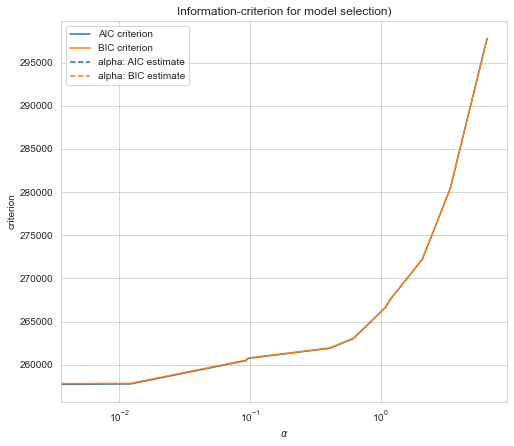

In [347]:
plot_aic_bic(alpha_aic=alpha_aic, alpha_bic=alpha_bic, results=results)

According to AIC and BIC criterion good alpha value is 0.

###### __Ridge Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [348]:
grid_res_lr_df_gas[grid_res_lr_df_gas.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0           8.030473               8.881846      Ridge              1e-08
1           8.030473               8.881846      Ridge              1e-07
2           8.030473               8.881846      Ridge              1e-06
3           8.030473               8.881846      Ridge              1e-05
4           8.030473               8.881846      Ridge             0.0001
5           8.030473               8.881841      Ridge              0.001
6           8.030473               8.881795      Ridge               0.01
7           8.030473               8.881332      Ridge                0.1
8           8.030498               8.876794      Ridge                  1
9           8.032520               8.839102      Ridge                 10
10          8.094992               8.761643      Ridge                100
11          8.316408               8.949233      Ridge               1000
12          8.778942               9.323730      Ridge              10000
13         10.333445              10.634421      Ridge             100000

In the case of Rigde best alpha value is 100 where validation score is minimized.

###### __Best Regularization with optimal penalty parameter__

Top 3 results from experiment:

In [351]:
grid_res_lr_df_gas[show_cols].sort_values(by=['mean_validation_score']).head(3)

mean_train_score  mean_validation_score model_name param_model__alpha
10          8.094992               8.761643      Ridge                100
20          8.036236               8.802989      Lasso               0.01
9           8.032520               8.839102      Ridge                 10

In the gas dataset, both Lasso and Ridge Regularization reach the same optimal results for average RMSE on training and validation sets. These results are also very close for Linear Regression without regularization and lies in within 8-8.8 RMSE score. Ridge regularization seem to perform slighlty better than Lasso, therefore the best regularization scheme for this dataset is Ridge with alpha 100.

In [44]:
# TODO experiment with different categorical encoding.

#### Question 10

The same experiments as Q9 applied on unscaled features.

##### __Diamond Dataset Not scaled Feature results__

In [45]:
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_diamonds_unscaled, y=y_diamonds, 
                                  model_name='Linear Regression (OLS)')

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.2805967946167
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850984


Check RMSE results for each of the 10-fold:

In [46]:
print('Train RMSEs:', cv_results_lr['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr['test_score']*(-1.))

Train RMSEs: [1246.67693953 1248.66216822 1230.78437231 1190.65068211  954.23438537
 1157.68140298 1256.25260037 1252.99820555 1264.05281144 1260.81240006]
Validation RMSEs:  [ 942.74216047  918.48055067 1112.58133725 1480.56810359 2806.51518647
 1699.75830566  815.69881421  877.61209435  670.86071043  725.63324541]


In [47]:
grid_search_lr_unscl, grid_res_lr_df_unscl = linear_model_exp(X=X_diamonds_unscaled, y=y_diamonds)

In [48]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_unscl[grid_res_lr_df_unscl.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14       1206.280597            1205.045051      Lasso              1e-08
15       1206.280597            1205.045051      Lasso              1e-07
16       1206.280597            1205.045053      Lasso              1e-06
17       1206.280597            1205.045073      Lasso              1e-05
18       1206.280597            1205.045263      Lasso             0.0001
19       1206.280597            1205.047165      Lasso              0.001
20       1206.280609            1205.066857      Lasso               0.01
21       1206.281892            1205.272222      Lasso                0.1
22       1206.403372            1207.533286      Lasso                  1
23       1215.137979            1238.590955      Lasso                 10
24       1362.777782            1459.776195      Lasso                100
25       2049.825908            1984.620077      Lasso               1000
26       3957.162324            3544.036398      Lasso              10000
27       3957.162324            3544.036398      Lasso             100000

In [49]:
grid_res_lr_df_unscl[grid_res_lr_df_unscl.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
2        1206.280597            1205.045051      Ridge              1e-06
3        1206.280597            1205.045055      Ridge              1e-05
4        1206.280597            1205.045088      Ridge             0.0001
5        1206.280597            1205.045421      Ridge              0.001
6        1206.280597            1205.048757      Ridge               0.01
7        1206.280619            1205.082125      Ridge                0.1
8        1206.282816            1205.417296      Ridge                  1
9        1206.492542            1208.905905      Ridge                 10
10       1220.380991            1249.715537      Ridge                100
11       1388.872280            1472.734228      Ridge               1000
12       1597.964835            1620.737422      Ridge              10000
13       2266.684099            2074.013462      Ridge             100000

##### __Gas Dataset Not scaled Feature results__

In [352]:
model_lr_gas = LinearRegression()
cv_results_lr_gas = apply_cv_to_model(model=model_lr_gas, 
                                  X=X_gas_unscaled, y=y_gas, 
                                  model_name='Linear Regression (OLS)')

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.030473106723004
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.881846484410753


Check RMSE results for each of the 10-fold:

In [353]:
print('Train RMSEs:', cv_results_lr_gas['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr_gas['test_score']*(-1.))

Train RMSEs: [8.20232426 8.0507639  8.1187614  8.17650722 7.74108808 7.83083707
 7.79695147 8.26129408 8.19835912 7.92784446]
Validation RMSEs:  [ 7.43536346  8.57794857  7.89249311  7.21361859 11.91720141 10.28186932
 11.55608868  6.192516    7.87080299  9.88056272]


In [354]:
grid_search_lr_unscl_gas, grid_res_lr_df_unscl_gas = linear_model_exp(X=X_gas_unscaled, y=y_gas)

In [355]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_unscl_gas[grid_res_lr_df_unscl_gas.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14          8.030497               8.890395      Lasso              1e-08
15          8.030497               8.890395      Lasso              1e-07
16          8.030497               8.890389      Lasso              1e-06
17          8.030497               8.890334      Lasso              1e-05
18          8.030495               8.889781      Lasso             0.0001
19          8.030495               8.884250      Lasso              0.001
20          8.031513               8.841661      Lasso               0.01
21          8.036915               8.728267      Lasso                0.1
22          8.166387               8.714142      Lasso                  1
23          9.562444               9.933988      Lasso                 10
24         11.656838              11.747458      Lasso                100
25         11.656838              11.747458      Lasso               1000
26         11.656838              11.747458      Lasso              10000
27         11.656838              11.747458      Lasso             100000

In [356]:
grid_res_lr_df_unscl_gas[grid_res_lr_df_unscl_gas.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0           8.030473               8.881846      Ridge              1e-08
1           8.030473               8.881846      Ridge              1e-07
2           8.030473               8.881846      Ridge              1e-06
3           8.030473               8.881846      Ridge              1e-05
4           8.030473               8.881846      Ridge             0.0001
5           8.030473               8.881846      Ridge              0.001
6           8.030473               8.881843      Ridge               0.01
7           8.030473               8.881816      Ridge                0.1
8           8.030473               8.881545      Ridge                  1
9           8.030482               8.878971      Ridge                 10
10          8.030814               8.861215      Ridge                100
11          8.032528               8.786004      Ridge               1000
12          8.056832               8.580556      Ridge              10000
13          8.412807               8.791324      Ridge             100000

__Does feature scaling play any role (in the cases with and without regularization)?__

For diamonds data, Ridge Regression on scaled data has lower average RMSE values for the alpha > 10 compared the same lambda values applied on unscaled data on Ridge. For Lasso, we see that for larger alpha values, we see the same trend, scaled data has either lower or very similar value compared the unscaled data. 
The trends are same both in train and validation sets. This experiment shows that scaling our data is a good technique, which helps us getting better avg. RMSE scores especially against higher penalty regularization parameter values (seen from above tables). It is also important to note that the best/optimal avg. RMSE values found for scaled and unscaled data are almost same for optimal Ridge and optimal Lasso alpha values lying in the 1205-1206 range. For the unscaled data, the optimal value for regularization parameters are smaller, for Ridge optimal alpha is 1 and for Lasso alpha is 0.1.

From the experiments on diamonds data above, scaling data doesn't seem to play a role on the case without regularization.
For the regularization on the other hand, scaling improves the avg. RMSE scores across different lambda values. This means for unscaled data the choice of regularization parameter is more crucial since the RMSE results can explode and grow very quickly when the data is unscaled and an unoptimal lambda parameter is chosen. 



In [362]:
print('Diamonds Data Scaled Best Results')
display(grid_res_lr_df[show_cols].sort_values(by=['mean_validation_score']).head(3))
print('Diamons Data Unscaled Best Results')
grid_res_lr_df_unscl[show_cols].sort_values(by=['mean_validation_score']).head(3)

Diamonds Data Scaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
14       1206.280597            1205.045051      Lasso              1e-08

Diamons Data Unscaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
14       1206.280597            1205.045051      Lasso              1e-08
1        1206.280597            1205.045051      Ridge              1e-07

For the gas data, the validation scores for scaled and unscaled data are again very similar. Unscaled results are slightly better than the scaled ones as it can be seen below. But it doesn't play a big role.

In [363]:
print('Gas Data Scaled Best Results')
display(grid_res_lr_df_gas[show_cols].sort_values(by=['mean_validation_score']).head(3))
print('Gas Data Unscaled Best Results')
grid_res_lr_df_unscl_gas[show_cols].sort_values(by=['mean_validation_score']).head(3)

Gas Data Scaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
10          8.094992               8.761643      Ridge                100
20          8.036236               8.802989      Lasso               0.01
9           8.032520               8.839102      Ridge                 10

Gas Data Unscaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
12          8.056832               8.580556      Ridge              10000
22          8.166387               8.714142      Lasso                  1
21          8.036915               8.728267      Lasso                0.1

#### Question 11

__Some linear regression packages return p-values for different features. What is the meaning of them and how can you infer the most significant features?__


P-values for each feature tests a null hypothesis that the coefficient has no effect (equal to 0). A typical threshold for p-value is 0.05 (corresponds to 95% confidence interval. A p-value lower than threshold ( < 0.05) means we should reject the null hypothesis and the feature is important for the prediction of the target variable. A p-value higher than threshold, means that the feature is statistically not significant to predict the target variable, the change in target variable is not associated with the feature. The p-values can be used to find most meaningful feature and may be used to decide which features to keep in the model and which ones we can remove.

scipy.stats.linregress and statsmodels.regression.linear_model.OLS are two library models that returns p-values for each feature where we can infer most significant features using them. I experimented with statsmodels.regression.linear_model.OLS on diamonds dataset to find important features for scaled and unscaled dataset:

##### __Diamonds Data__

__Diamonds Data Scaled (statsmodels.regression.linear_model.OLS) Results__

In [50]:
ols_stats_model = sm.OLS(y_diamonds,X_diamonds)
ols_stats_model_results = ols_stats_model.fit()
print('OLS params: \n', ols_stats_model_results.params)

OLS params: 
 carat      5092.655074
depth      -114.319163
table       -59.802654
x          -984.480857
y            49.963989
z           -20.679798
cut         134.816544
color       548.941110
clarity     826.612634
dtype: float64


These are the coefficients assigned to each feature. The highest coefficient is given to carat meaning carat has the highest positive impact on the diamond price. Whereas x has the largest negative coefficient which means x also has a high impact, this time inverse relation, on the diamond price: lower the x the higher price we can assign.

__OLS Summary for Scaled Diamonds Data:__

In [51]:
print(ols_stats_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                              5100.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):                        0.00
Time:                        15:13:35   Log-Likelihood:                     -5.2549e+05
No. Observations:               53940   AIC:                                  1.051e+06
Df Residuals:                   53931   BIC:                                  1.051e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

By looking the p-values in the above table (P >|t|), we can see that carat, depth, x, cut, color, clarity values have p-values lower than 0.05 and are the most important features. The R^2 and adjusted R^2 values for the model is 0.46 which is pretty low. 

__Diamonds Data Unscaled (statsmodels.regression.linear_model.OLS) Results__

When we used unscaled data to apply OLS the R^2 and adjusted R^2 results are very high, 0.953 with all the diamonds features. Also all the features have p-values lower than 0.05. This means that with unscaled features OLS can fit a good linear model where all features are important for the prediction.

In [52]:
ols_stats_model = sm.OLS(y_diamonds,X_diamonds_unscaled)
ols_stats_model_results = ols_stats_model.fit()
print('OLS params: \n', ols_stats_model_results.params)
print(ols_stats_model_results.summary())

OLS params: 
 carat      10587.758498
depth        -41.693458
table         -8.901253
x           -770.488938
y             60.599056
z           -121.711175
cut          144.798827
color        324.416568
clarity      506.522714
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.210e+05
Date:                Tue, 08 Mar 2022   Prob (F-statistic):                        0.00
Time:                        15:13:35   Log-Likelihood:                     -4.5975e+05
No. Observations:               53940   AIC:                                  9.195e+05
Df Residuals:                   53931   BIC:                                  9.196e+05
Df Model:                           9              

##### __Gas Data__

__Gas Data Scaled (statsmodels.regression.linear_model.OLS) Results__

In [365]:
ols_stats_model_gas = sm.OLS(list(y_gas),X_gas)
ols_stats_model_results_gas = ols_stats_model_gas.fit()
print('OLS params: \n', ols_stats_model_results_gas.params)

OLS params: 
 AT     -12.906630
AP      -1.493527
AH      -3.317940
AFDP     0.289539
GTEP     0.568738
TIT     19.725546
TAT     -7.755266
TEY    -28.881104
CDP      2.063782
year    -1.339015
dtype: float64


These are the coefficients assigned to each feature. The highest absolute coefficient is given to TEY which has the highest negative impact on the NOX. Whereas TIT has the largest positive coefficient, and second biggest absolute coefficient, which means TIT also has a high impact, this time it has positive relation, on the NOX prediction.

__OLS Summary for Scaled Gas Data:__

In [366]:
print(ols_stats_model_results_gas.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              60.38
Date:                Tue, 08 Mar 2022   Prob (F-statistic):                   2.89e-122
Time:                        23:18:00   Log-Likelihood:                     -2.0590e+05
No. Observations:               36733   AIC:                                  4.118e+05
Df Residuals:                   36723   BIC:                                  4.119e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

By looking the p-values in the above table (P >|t|), we can see that all features except AFDP, GTEP and CDP are important features for NOX prediction. They aññ have p-values lower than 0.05 and are the most important features. The R^2 and adjusted R^2 values for the model is 0.016 which is pretty low. 

__Gas Data Unscaled (statsmodels.regression.linear_model.OLS) Results__

When we used unscaled data to apply OLS the R^2 and adjusted R^2 results are very high, 0.985 with all the diamonds features. Also all the features have p-values lower than 0.05 except GTEP. This means that with unscaled features OLS can fit a good linear model where all features are important (except GTEP) for the prediction.

In [367]:
ols_stats_model_gas = sm.OLS(list(y_gas),X_gas_unscaled)
ols_stats_model_results_gas = ols_stats_model_gas.fit()
print('OLS params: \n', ols_stats_model_results_gas.params)
print(ols_stats_model_results_gas.summary())

OLS params: 
 AT     -1.717197
AP     -0.240365
AH     -0.230917
AFDP    0.379716
GTEP    0.102995
TIT     1.105622
TAT    -1.133994
TEY    -1.793823
CDP     1.505362
year   -0.959536
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          2.441e+05
Date:                Tue, 08 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:21:32   Log-Likelihood:                     -1.2885e+05
No. Observations:               36733   AIC:                                  2.577e+05
Df Residuals:                   36723   BIC:                                  2.578e+05
Df Model:                          10                                                  
Covarianc

## Polynomial Regression

#### Question 12

For each polynomial regression model I applied 10-fold cross-validation and measured average RMSE errors for training and validation sets.

For this experiment, I created a pipeline to extract polynomial features with PolynomialFeatures() in sklearn and applied Linear Regression on the compound features (I used Lasso and Ridge Regression models for regularization). Grid search over 10-fold cv is applied to tune degrees for polynomial features and alpha for the regularization. Degree range is [2, 3, 4] and alpha range is $[10^{-4}, 10^3]$. 

In [53]:
def model_experiment(X, y, full_pipeline, params, fname, model_file, cv, rerun, search_type='grid', n_iter=10, scoring='neg_root_mean_squared_error', verbose=0, model=None):
    if os.path.isfile(fname) and (not rerun):
        grid_results_df = pd.read_csv(fname)
        #load your model for further usage
        grid_search = joblib.load(model_file)
        return grid_search, grid_results_df
    else:
        t0 = time.time()
        if scoring == 'neg_root_mean_squared_error':
            refit=True
        else:
            refit='RMSE'
        
        if search_type=='randomized':
            grid_search = RandomizedSearchCV(full_pipeline, param_distributions=params, 
                                     n_iter=n_iter, 
                                     cv=cv,
                                     scoring=scoring,
                                     refit=refit,
                                     return_train_score=True,
                                     verbose=verbose)
        elif search_type=='bayes':
            if not model:
                grid_search = BayesSearchCV(full_pipeline, search_spaces=params, 
                                         n_iter= n_iter,
                                         cv=cv,  
                                         scoring=scoring,
                                         refit=refit,
                                         return_train_score=True,
                                         verbose=verbose)
            else:
                grid_search = BayesSearchCV(model, search_spaces=params, 
                                         n_iter= n_iter,
                                         cv=cv,  
                                         scoring=scoring,
                                         refit=refit,
                                         return_train_score=True,
                                         verbose=verbose)
    
        else: # do grid search
            grid_search = GridSearchCV(full_pipeline, params, cv=cv, 
                                       scoring=scoring, 
                                       refit=refit,
                                       return_train_score=True,
                                       verbose=verbose)
            
        cv_results = grid_search.fit(X, y)
        t1 = time.time()
        elapsed = t1-t0
        print('Time for experiment:',time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
        grid_results_df = pd.DataFrame(grid_search.cv_results_)
        if scoring == 'neg_root_mean_squared_error':
            grid_results_df['mean_train_score'] = grid_results_df['mean_train_score']*-1
            grid_results_df['mean_test_score'] = grid_results_df['mean_test_score']*-1
            grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
        else:
            grid_results_df['mean_train_RMSE'] = grid_results_df['mean_train_RMSE']*-1
            grid_results_df['mean_test_RMSE'] = grid_results_df['mean_test_RMSE']*-1
            grid_results_df.rename(columns={'mean_test_RMSE': 'mean_validation_RMSE'}, inplace=True)
        
            
        grid_results_df.to_csv(fname)
        #save your model or results
        joblib.dump(grid_search, model_file)
        #grid_results_df.head()
        return grid_search, grid_results_df
        
def polynomial_feat_linear_model_exp(X,y, data_name, search_type, interaction_only='False', cv=10, n_iter=10, rerun=False, post_fix=''):
    fname = f'exp_results/{data_name}_polynomial_feat_linear_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_polynomial_feat_linear_model{post_fix}.pkl'

    full_pipeline = Pipeline([('poly_features', "passthrough"),
                             ('model', "passthrough")
                    ])
    alphas = [10**(x) for x in range(-4,4)]
    degrees = [2,3,4]
    params = {
        "poly_features": [PolynomialFeatures(interaction_only=interaction_only)],
        "model": [Ridge(random_state=rand_seed),
                  Lasso(random_state=rand_seed)],
        "poly_features__degree":degrees,
        "model__alpha": alphas
    }

    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter)
    #grid_results_df['model_name']= grid_results_df.param_model.apply(lambda x: 'Ridge' if type(x)==Ridge else 'Lasso')

    return grid_search, grid_results_df

##### __Diamond Data__

In [54]:
 grid_search_poly, grid_res_poly_df = polynomial_feat_linear_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                                                       data_name='diamonds', search_type='grid')
    
    

##### __Polynomial Regression Experiment Results__

Top 10 hyperparameter combination results based on based mean validation score. From the below table, the best combinations 10-fold avg train RMSE: 921.57  avg validation RMSE:  882.22 which are way better than the Linear Regression results which were around 1205-1206 RMSE results for both metrics.

In [105]:
show_cols =['mean_train_score','mean_validation_score','param_model','param_model__alpha','param_poly_features__degree']
grid_res_poly_df[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  \
42        921.572213             882.226435   
39        782.419320            1129.772967   
36        763.272005            1615.358097   
21        795.955216            1667.221668   
24        757.769711            1777.435298   
27        757.769829            1777.748836   
30        757.771652            1780.882997   
45       1841.870944            1790.712541   
33        757.857294            1809.238839   
46       2023.787034            1902.183814   

                           param_model  param_model__alpha  \
42  Lasso(alpha=100, random_state=142)            100.0000   
39  Lasso(alpha=100, random_state=142)             10.0000   
36  Lasso(alpha=100, random_state=142)              1.0000   
21             Ridge(random_state=142)           1000.0000   
24  Lasso(alpha=100, random_state=142)              0.0001   
27  Lasso(alpha=100, random_state=142)              0.0010   
30  Lasso(alpha=100, random_state=142)              0.0100   
45  Lasso(alpha=100, random_state=142)           1000.0000   
33  Lasso(alpha=100, random_state=142)              0.1000   
46  Lasso(alpha=100, random_state=142)           1000.0000   

    param_poly_features__degree  
42                            2  
39                            2  
36                            2  
21                            2  
24                            2  
27                            2  
30                            2  
45                            2  
33                            2  
46                            3

__Best model found from GridSearch:__

The best model is Lasso with alpha 100 and PolynomialFeatures set with degree 2.

In [56]:
best_model_poly = grid_search_poly.best_estimator_
print('Best Model:',best_model_poly)
print('Best Model Params:',grid_search_poly.best_params_)

Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('model', Lasso(alpha=100, random_state=142))])

###### __Coefficient of the best model and Most Salient Features:__

Since the selected best model is with Lasso Regularization, we can see that most of the features have 0 coefficients.

In [58]:
best_model_poly = grid_search_poly.best_estimator_
feature_names = best_model_poly['poly_features'].get_feature_names_out()

coefs_df = pd.DataFrame(
    best_model_poly['model'].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs_df

Coefficients
1                  0.000000
carat           3819.165766
depth             -0.000000
table             -0.000000
x                  0.000000
y                  0.000000
z                  0.000000
cut               19.424984
color            379.512189
clarity          736.942242
carat^2            0.000000
carat depth       -0.000000
carat table       -0.000000
carat x          255.502250
carat y            0.000000
carat z            0.000000
carat cut         36.487862
carat color      340.220949
carat clarity    658.568956
depth^2          -25.612413
depth table        0.000000
depth x           -0.000000
depth y           -0.000000
depth z           -0.000000
depth cut          0.000000
depth color        0.000000
depth clarity      0.000000
table^2           -0.000000
table x           -0.000000
table y           -0.000000
table z           -0.000000
table cut          0.000000
table color        0.000000
table clarity      0.000000
x^2              272.697483
x y               83.223653
x z                0.000000
x cut              0.000000
x color            0.000000
x clarity          0.000000
y^2               -0.961110
y z                0.000000
y cut              0.000000
y color            0.000000
y clarity          0.000000
z^2                0.000000
z cut              0.000000
z color            0.000000
z clarity          0.000000
cut^2             -5.943162
cut color         -0.000000
cut clarity       -0.000000
color^2          -58.635986
color clarity     79.471302
clarity^2         -0.000000

Lasso Regression assigns 0 values to coefficients as seen above, to understand salient features better, I plotted the non-zero coefficients only.

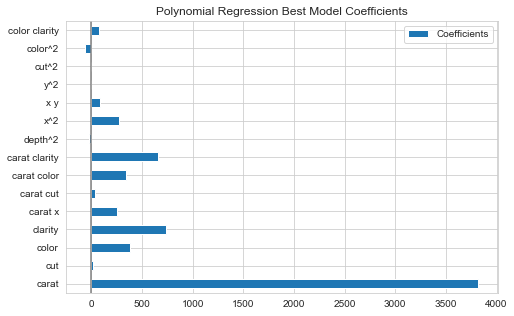

In [59]:
coefs_df[coefs_df.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Polynomial Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest absolute coefficient values:

In [97]:
coefs_df['coef_absolute'] = coefs_df.Coefficients.apply(lambda x: abs(x))
coefs_df[coefs_df.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

carat     clarity  carat clarity       color  \
Coefficients   3819.165766  736.942242     658.568956  379.512189   
coef_absolute  3819.165766  736.942242     658.568956  379.512189   

               carat color         x^2    carat x        x y  color clarity  \
Coefficients    340.220949  272.697483  255.50225  83.223653      79.471302   
coef_absolute   340.220949  272.697483  255.50225  83.223653      79.471302   

                 color^2  carat cut    depth^2        cut     cut^2      y^2  
Coefficients  -58.635986  36.487862 -25.612413  19.424984 -5.943162 -0.96111  
coef_absolute  58.635986  36.487862  25.612413  19.424984  5.943162  0.96111

From the coefficients, we can see that Lasso assigns 0 to many of the features and only small number of them have non-zero coefficients.
Within the most salient features, the most important one is carat with the biggest coefficient 3819.17. This means the increase in price is positively correlated with the carat coefficient. Clarity is the second most important feature followed by compound carat clarit feature, color, carat color, x^2 and carat x. Color^2, depth^2, cut^2 and y^2 also has negative correlation with diamond price. Decreasing either one of them leads to increase the price.
The coefficient values also matter, the bigger the absolute coefficient value means the bigger impact it has on the target variable (pricing the diamond), the more important the feature in terms of predicting the target variable. 

##### __Gas Data__

In [368]:
 grid_search_poly_gas, grid_res_poly_df_gas = polynomial_feat_linear_model_exp(X=X_gas, y=y_gas, cv=10,
                                                                       data_name='gas', search_type='grid')


Time for experiment: 00h12m00s


##### __Polynomial Regression Experiment Results__

Top 10 hyperparameter combination results based on based mean validation score. From the below table, the best combinations 10-fold avg train RMSE: 921.57  avg validation RMSE:  882.22 which are way better than the Linear Regression results which were around 1205-1206 RMSE results for both metrics.

TODO fix above:

In [369]:
show_cols =['mean_train_score','mean_validation_score','param_model','param_model__alpha','param_poly_features__degree']
grid_res_poly_df_gas[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  \
35          5.719778               7.155798   
34          5.827271               7.171435   
22          5.508430               7.226445   
23          5.273528               7.369680   
33          6.246073               7.436532   
18          5.682998               7.459753   
21          6.055840               7.464865   
19          5.119546               7.514624   
20          4.895412               7.588859   
31          5.156848               7.655462   

                           param_model param_model__alpha  \
35  Lasso(alpha=0.1, random_state=142)                0.1   
34  Lasso(alpha=0.1, random_state=142)                0.1   
22             Ridge(random_state=142)               1000   
23             Ridge(random_state=142)               1000   
33  Lasso(alpha=0.1, random_state=142)                0.1   
18             Ridge(random_state=142)                100   
21             Ridge(random_state=142)               1000   
19             Ridge(random_state=142)                100   
20             Ridge(random_state=142)                100   
31  Lasso(alpha=0.1, random_state=142)               0.01   

   param_poly_features__degree  
35                           4  
34                           3  
22                           3  
23                           4  
33                           2  
18                           2  
21                           2  
19                           3  
20                           4  
31                           3

__Best model found from GridSearch:__

The best model is Lasso with alpha 100 and PolynomialFeatures set with degree 2. TODO fix here.

In [ ]:
best_model_poly_gas = grid_search_poly_gas.best_estimator_
print('Best Model:',best_model_poly_gas)
print('Best Model Params:',best_model_poly_gas.best_params_)

###### __Coefficient of the best model and Most Salient Features:__

Since the selected best model is with Lasso Regularization, we can see that most of the features have 0 coefficients.
TODO fix here.

In [ ]:
best_model_poly_gas = best_model_poly_gas.best_estimator_
feature_names_gas = best_model_poly_gas['poly_features'].get_feature_names_out()

coefs_df_gas = pd.DataFrame(
    best_model_poly_gas['model'].coef_,
    columns=["Coefficients"],
    index=feature_names_gas,
)
coefs_df_gas

Lasso Regression assigns 0 values to coefficients as seen above, to understand salient features better, I plotted the non-zero coefficients only. todo fix here.

In [ ]:
coefs_df_gas[coefs_df_gas.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Polynomial Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest absolute coefficient values:

In [ ]:
coefs_df_gas['coef_absolute'] = coefs_df_gas.Coefficients.apply(lambda x: abs(x))
coefs_df_gas[coefs_df_gas.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

From the coefficients, we can see that Lasso assigns 0 to many of the features and only small number of them have non-zero coefficients.
Within the most salient features, the most important one is carat with the biggest coefficient 3819.17. This means the increase in price is positively correlated with the carat coefficient. Clarity is the second most important feature followed by compound carat clarit feature, color, carat color, x^2 and carat x. Color^2, depth^2, cut^2 and y^2 also has negative correlation with diamond price. Decreasing either one of them leads to increase the price.
The coefficient values also matter, the bigger the absolute coefficient value means the bigger impact it has on the target variable (pricing the diamond), the more important the feature in terms of predicting the target variable. 

TODO fix here.

#### Question 13

The experiment is done for degrees 2, 3, and 4. Given that degree=1 would be just linear results, and we want to see the results for polynomial features, I omitted degree=1 in the experiment. I also didn't include degrees higher than 4 because given the dataset, the amount of compound features created would be too much with degrees higher than 5. Another reason is that both dataset are relatively small 30-50k samples, very high degrees would more likely to cause overfit rather then help generalizing the model.  

##### __Diamonds Data__


__What degree of polynomial is best?__
From experiment results we can see that the best degree is 2. The first 9 of the top 10 combinations of our experiment shows that 2 is the best degree values anf Lasso is a better regularization for this dataset.

Best model parameters:

In [61]:
grid_search_poly.best_params_

{'model': Lasso(alpha=100, random_state=142),
 'model__alpha': 100,
 'poly_features': PolynomialFeatures(),
 'poly_features__degree': 2}

Top 10 combinations from gridsearch results sorted with lowest RMSE validation scores:

In [62]:
grid_res_poly_df[show_cols].sort_values(by='mean_validation_score', ascending=True).head(10)

mean_train_score  mean_validation_score  \
42        921.572213             882.226435   
39        782.419320            1129.772967   
36        763.272005            1615.358097   
21        795.955216            1667.221668   
24        757.769711            1777.435298   
27        757.769829            1777.748836   
30        757.771652            1780.882997   
45       1841.870944            1790.712541   
33        757.857294            1809.238839   
46       2023.787034            1902.183814   

                           param_model  param_model__alpha  \
42  Lasso(alpha=100, random_state=142)            100.0000   
39  Lasso(alpha=100, random_state=142)             10.0000   
36  Lasso(alpha=100, random_state=142)              1.0000   
21             Ridge(random_state=142)           1000.0000   
24  Lasso(alpha=100, random_state=142)              0.0001   
27  Lasso(alpha=100, random_state=142)              0.0010   
30  Lasso(alpha=100, random_state=142)              0.0100   
45  Lasso(alpha=100, random_state=142)           1000.0000   
33  Lasso(alpha=100, random_state=142)              0.1000   
46  Lasso(alpha=100, random_state=142)           1000.0000   

    param_poly_features__degree  
42                            2  
39                            2  
36                            2  
21                            2  
24                            2  
27                            2  
30                            2  
45                            2  
33                            2  
46                            3

##### __Gas Data__


__What degree of polynomial is best?__
From experiment results we can see that the best degree is 2. The first 9 of the top 10 combinations of our experiment shows that 2 is the best degree values anf Lasso is a better regularization for this dataset. TODO fix here.

Best model parameters:

In [61]:
grid_search_poly_gas.best_params_

{'model': Lasso(alpha=100, random_state=142),
 'model__alpha': 100,
 'poly_features': PolynomialFeatures(),
 'poly_features__degree': 2}

Top 10 combinations from gridsearch results sorted with lowest RMSE validation scores:

In [62]:
grid_res_poly_df_gas[show_cols].sort_values(by='mean_validation_score', ascending=True).head(10)

mean_train_score  mean_validation_score  \
42        921.572213             882.226435   
39        782.419320            1129.772967   
36        763.272005            1615.358097   
21        795.955216            1667.221668   
24        757.769711            1777.435298   
27        757.769829            1777.748836   
30        757.771652            1780.882997   
45       1841.870944            1790.712541   
33        757.857294            1809.238839   
46       2023.787034            1902.183814   

                           param_model  param_model__alpha  \
42  Lasso(alpha=100, random_state=142)            100.0000   
39  Lasso(alpha=100, random_state=142)             10.0000   
36  Lasso(alpha=100, random_state=142)              1.0000   
21             Ridge(random_state=142)           1000.0000   
24  Lasso(alpha=100, random_state=142)              0.0001   
27  Lasso(alpha=100, random_state=142)              0.0010   
30  Lasso(alpha=100, random_state=142)              0.0100   
45  Lasso(alpha=100, random_state=142)           1000.0000   
33  Lasso(alpha=100, random_state=142)              0.1000   
46  Lasso(alpha=100, random_state=142)           1000.0000   

    param_poly_features__degree  
42                            2  
39                            2  
36                            2  
21                            2  
24                            2  
27                            2  
30                            2  
45                            2  
33                            2  
46                            3

##### __What does a very high-order polynomial imply about the fit on the training data? How do you choose this parameter?__


With a higher-order polynomial, we can create more complex models that covers larger hypothesis spaces. With increasing model complexity, it means we can fit the data better, however, if the degree of polynomial is higher than the optimal degree that data lies, then model may overfit the data. In case of overfitting, the fitted curve will start to memorize the training data rather then learn to generalize and find patterns. When model overfits, the training error would be low and test/validation errors would be high since it perform badly on the unseen data. We can see this from the experiment results in the above table as well. For higher degrees we see that training errors (avg RMSEs) are very low but the avg. validation scores are very high compared to the training score. 

On the other hand, if the degree order is too small, the model cannot learn enough from the data and model can underfit resulting in high training and validation errors. 
In order to avoid overfitting or underfitting, and have a model that generalizes well, we need to choose a degree that matches with the true structure of the data. This happens when the the model has a good training score and the gap between the training and validation scores are lowest. One way to choosee optimal degree parameter, is to run cross validation with different degree values and compare the avg. training and validation results. Then choose a degree where model has low trainining RMSE and low test RMSE. The optimal point is generally when the model has low training RMSE and the gap beetween train and validation score is also lowest.

#### Question 14

__For the diamond dataset it might make sense to craft new features such as z = x1 × x2, etc. Explain why this might make sense and check if doing so will boost accuracy.__

Depending on some dataset a compound feature might make sense on predicting the target variable. For example, for the diamonds dataset the diamond price might be correlated with the diamond volume, and diamond volume can be represented by x*y*z. Using compounding features (combination of different features) might be more helpful in predicting target variable rather than individual columns by itself. There could be cases where individual feature might not contribute as much as a compound feature to the prediction. 

I tried 2 approaches to craft new features such as z= x1 x x2. 

Approach 1: Use interaction_only=True in Polynomial Features and run only for the combinations of different features. In this approach I created all possible interacted features and checked whether any of them are important features. 

Approach 2: Create craft features by hand for the combinations that makes sense and could be helpful for prediction of target variable:

For diamonds dataset new hand crafted features:

    - volume of diamond: x * y * z
    - table * depth
    - density of diamond: carat / (x*y*z)
    
In the results below saw that approach 1 helped us improve the accuracy. Approach 2 by adding only few selected hand-crafted features, instead of the regular features worsen the accuracy.


###### __Approach 1: Polynomial Feature on Interactions only__

I applied a randomized search with 12 samples (n_iter) with the same parameter range on q12, but this time I only used the compound features to feed in the linear model. I did 10-fold cv and Lasso, Ridge Regularizations.

In [65]:
grid_search_poly_interaction_only, grid_res_poly_inter_only_df = polynomial_feat_linear_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                                                       data_name='diamonds', interaction_only=True,
                                                                       search_type='grid', rerun=False,
                                                                       post_fix='interaction_only')
    
    

Polynomial Feature Interaction Only features experiment results on top 10 combination:

In [107]:
grid_res_poly_inter_only_df[show_cols].sort_values(by=['mean_validation_score']).head(10)

mean_train_score  mean_validation_score  \
39        805.512807             813.970583   
40        679.765887             825.384492   
42        927.309710             873.199024   
21        811.508988             874.116912   
41        647.222578             883.514943   
43        874.565986             900.154033   
44        859.818400             937.391952   
22        683.784705            1067.001516   
23        647.120971            1101.171040   
18        789.987240            1108.538274   

                          param_model  param_model__alpha  \
39  Lasso(alpha=10, random_state=142)                10.0   
40  Lasso(alpha=10, random_state=142)                10.0   
42  Lasso(alpha=10, random_state=142)               100.0   
21            Ridge(random_state=142)              1000.0   
41  Lasso(alpha=10, random_state=142)                10.0   
43  Lasso(alpha=10, random_state=142)               100.0   
44  Lasso(alpha=10, random_state=142)               100.0   
22            Ridge(random_state=142)              1000.0   
23            Ridge(random_state=142)              1000.0   
18            Ridge(random_state=142)               100.0   

    param_poly_features__degree  
39                            2  
40                            3  
42                            2  
21                            2  
41                            4  
43                            3  
44                            4  
22                            3  
23                            4  
18                            2

The avg 10-fold CV Train RMSE:805.51 and Validation RMSE=813.97 with interaction only features are much better then the Q12-13 results. This results the performances of the models.

In [109]:
print('Best model:\n',grid_search_poly_interaction_only.best_estimator_)
print('Best model parameters:\n',grid_search_poly_interaction_only.best_params_)

Best model:
 Pipeline(steps=[('poly_features', PolynomialFeatures(interaction_only=True)),
                ('model', Lasso(alpha=10, random_state=142))])
Best model parameters:
 {'model': Lasso(alpha=10, random_state=142), 'model__alpha': 10, 'poly_features': PolynomialFeatures(interaction_only=True), 'poly_features__degree': 2}


__The coefficients of the best found model with polynomial interactions only features (non-zero coeffs only):__

In [69]:
best_model_poly_interaction = grid_search_poly_interaction_only.best_estimator_
feature_names_inter = best_model_poly_interaction['poly_features'].get_feature_names_out()

coefs_df_inter = pd.DataFrame(
    best_model_poly_interaction['model'].coef_,
    columns=["Coefficients"],
    index=feature_names_inter,
)
coefs_df_inter[coefs_df_inter.Coefficients!=0]

Coefficients
carat           4034.341806
table            -32.671368
cut               93.303139
color            557.804933
clarity          918.785316
carat depth     -163.438333
carat table      -19.371410
carat x          384.641881
carat cut        101.794631
carat color      582.467856
carat clarity    937.881468
depth table       23.574794
depth y          173.265004
depth cut         29.052115
table clarity     -6.953471
x y              298.472237
x z              164.424270
x clarity         -3.652150
y z              -22.220218
y color           44.728856
cut color         12.634970
cut clarity        4.550465
color clarity    321.181135

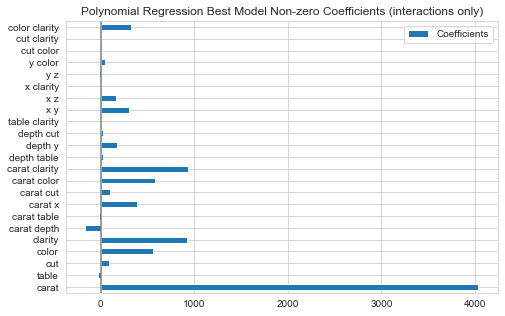

In [110]:
coefs_df_inter[coefs_df_inter.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Polynomial Regression Best Model Non-zero Coefficients (interactions only)")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest absolute coefficient values:

In [111]:
coefs_df_inter['coef_absolute'] = coefs_df_inter.Coefficients.apply(lambda x: abs(x))
coefs_df_inter[coefs_df_inter.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

carat  carat clarity     clarity  carat color  \
Coefficients   4034.341806     937.881468  918.785316   582.467856   
coef_absolute  4034.341806     937.881468  918.785316   582.467856   

                    color     carat x  color clarity         x y     depth y  \
Coefficients   557.804933  384.641881     321.181135  298.472237  173.265004   
coef_absolute  557.804933  384.641881     321.181135  298.472237  173.265004   

                     x z  ...    y color      table  depth cut  depth table  \
Coefficients   164.42427  ...  44.728856 -32.671368  29.052115    23.574794   
coef_absolute  164.42427  ...  44.728856  32.671368  29.052115    23.574794   

                     y z  carat table  cut color  table clarity  cut clarity  \
Coefficients  -22.220218    -19.37141   12.63497      -6.953471     4.550465   
coef_absolute  22.220218     19.37141   12.63497       6.953471     4.550465   

               x clarity  
Coefficients    -3.65215  
coef_absolute    3.65215  

[2 rows x 23 columns]

We can see that the most important features are very similar as in Q12-Q13, however the model is only using the compounds of different features now. 

###### __Approach 2.1: Hand-crafted features - Option 1- create compound features from raw data and then scale__

In this approach I only hand crafted new feature set. The process is I created the features from raw data and then scaled the. Then I checked the results on best found model and its parameters in Question 12 to see if the model performance is improved. Lasso Regression with 100 alpha is used:

In [125]:
diamonds_new_feat_df['z'].min()

0.0

In [127]:
diamonds_df['z'].describe()

count    53940.000000
mean         3.538734
std          0.705699
min          0.000000
25%          2.910000
50%          3.530000
75%          4.040000
max         31.800000
Name: z, dtype: float64

In [123]:
diamonds_new_feat_df[diamonds_new_feat_df['density']==np.Inf]

carat  cut  color  clarity  depth  table  price     x     y    z  \
2208    1.00  3.0    3.0      1.0   59.1   59.0   3144  6.55  6.48  0.0   
2315    1.01  3.0    2.0      0.0   58.1   59.0   3167  6.66  6.60  0.0   
4792    1.10  3.0    3.0      1.0   63.0   59.0   3696  6.50  6.47  0.0   
5472    1.01  3.0    4.0      1.0   59.2   58.0   3839  6.50  6.47  0.0   
10168   1.50  1.0    3.0      0.0   64.0   61.0   4734  7.15  7.04  0.0   
11183   1.07  4.0    4.0      1.0   61.6   56.0   4954  0.00  6.62  0.0   
11964   1.00  2.0    2.0      3.0   63.3   53.0   5142  0.00  0.00  0.0   
13602   1.15  4.0    3.0      3.0   59.2   56.0   5564  6.88  6.83  0.0   
15952   1.14  0.0    3.0      4.0   57.5   67.0   6381  0.00  0.00  0.0   
24395   2.18  3.0    2.0      1.0   59.4   61.0  12631  8.49  8.45  0.0   
24521   1.56  4.0    3.0      3.0   62.2   54.0  12804  0.00  0.00  0.0   
26124   2.25  3.0    1.0      2.0   61.3   58.0  15397  8.52  8.42  0.0   
26244   1.20  3.0    6.0      6.0   62.1   59.0  15689  0.00  0.00  0.0   
27113   2.20  3.0    2.0      2.0   61.2   59.0  17269  8.42  8.37  0.0   
27430   2.25  3.0    2.0      1.0   62.8   59.0  18036  0.00  0.00  0.0   
27504   2.02  3.0    2.0      3.0   62.7   53.0  18209  8.02  7.95  0.0   
27740   2.80  1.0    3.0      1.0   63.8   58.0  18792  8.90  8.85  0.0   
49557   0.71  1.0    4.0      1.0   64.1   60.0   2131  0.00  0.00  0.0   
49558   0.71  1.0    4.0      1.0   64.1   60.0   2132  0.00  0.00  0.0   
51507   1.12  3.0    3.0      0.0   60.4   59.0   2387  6.71  6.67  0.0   

       x*y*z  table*depth  density  
2208     0.0       3486.9      inf  
2315     0.0       3427.9      inf  
4792     0.0       3717.0      inf  
5472     0.0       3433.6      inf  
10168    0.0       3904.0      inf  
11183    0.0       3449.6      inf  
11964    0.0       3354.9      inf  
13602    0.0       3315.2      inf  
15952    0.0       3852.5      inf  
24395    0.0       3623.4      inf  
24521    0.0       3358.8      inf  
26124    0.0       3555.4      inf  
26244    0.0       3663.9      inf  
27113    0.0       3610.8      inf  
27430    0.0       3705.2      inf  
27504    0.0       3323.1      inf  
27740    0.0       3700.4      inf  
49557    0.0       3846.0      inf  
49558    0.0       3846.0      inf  
51507    0.0       3563.6      inf

In [131]:
# create new features: Option 1- create from raw data and then scale
diamonds_new_feat_df = diamonds_df.copy()
diamonds_new_feat_df['x*y*z'] = diamonds_new_feat_df['x']*diamonds_new_feat_df['y']*diamonds_new_feat_df['z']
diamonds_new_feat_df['table*depth'] = diamonds_new_feat_df['table']*diamonds_new_feat_df['depth']
diamonds_new_feat_df['density'] = diamonds_new_feat_df['carat']/ (diamonds_new_feat_df['x*y*z'])
diamonds_new_feat_df['density'] = diamonds_new_feat_df['density'].apply(lambda x: 0 if x==np.Inf else x)
diamonds_new_num_cols = ['carat', 'x','y','z','table','depth', 'x*y*z','table*depth', 'density' ]
diamonds_new_feat_df = feature_transformer_diamonds(data=diamonds_new_feat_df, 
                                                numeric_feats=diamonds_new_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=True)
display(diamonds_new_feat_df.head())
diamonds_new_feat_df.describe()

carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   
5 -1.029394 -1.705279 -2.002131 -1.245215  1.082358  0.242928    338   

          x         y         z     x*y*z  table*depth   density  
1 -1.587837 -1.536196 -1.571129 -1.171294    -1.188533 -0.489328  
2 -1.641325 -1.658774 -1.741175 -1.218533     0.728291 -0.183160  
3 -1.498691 -1.457395 -1.741175 -1.172894     1.094605 -0.396553  
4 -1.364971 -1.317305 -1.287720 -1.062372     0.521653  0.382562  
5 -1.240167 -1.212238 -1.117674 -0.996008     0.898804 -0.721797

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  \
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04   
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16   
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00   
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00   
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01   
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02   
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01   
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01   

              x*y*z   table*depth       density  
count  5.394000e+04  5.394000e+04  5.394000e+04  
mean   3.161480e-16 -1.559664e-16 -5.342639e-15  
std    1.000009e+00  1.000009e+00  1.000009e+00  
min   -1.659533e+00 -8.850773e+00 -2.871741e+01  
25%   -8.270555e-01 -7.116750e-01 -3.601900e-01  
50%   -1.922285e-01 -9.681727e-02 -3.771660e-02  
75%    5.239094e-01  6.054644e-01  3.051422e-01  
max    4.742502e+01  1.603977e+01  7.746588e+01

In [134]:
features_q14= [
    ['carat', 'x','y','z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x*y*z', 'table','depth', 'cut', 'color', 'clarity'],
    ['carat', 'x','y','z', 'table','depth', 'cut', 'color', 'clarity', 'density'],
    ['carat', 'x','y','z','table','depth', 'cut', 'color', 'clarity', 'x*y*z', 'table*depth','density']
]

for feat in features_q14:
    print('\n\nResults for features: ',feat)
    X_diamonds_new_feats= diamonds_new_feat_df[feat]

    model_lr_q14 = Lasso(alpha=100, random_state=rand_seed) 
    cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                      X=X_diamonds_new_feats, y=y_diamonds, 
                                      model_name='Lasso with new features')



Results for features:  ['carat', 'x', 'y', 'z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.257425103957
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.9244651005379


Results for features:  ['carat', 'x*y*z', 'table', 'depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1250.9522429042684
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.883579227349


Results for features:  ['carat', 'x', 'y', 'z', 'table', 'depth', 'cut', 'color', 'clarity', 'density']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2749901090597
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8990105660093


Results for features:  ['carat', 'x', 'y', 'z', 'table', 'depth', 'cut', 'color', 'clarity', 'x*y*z', 'table*depth', 'density']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.0241173671452
Lasso with new fe

By only using these 3 crafted features doesn't really help with the model performance, it rather detoriates.

###### __Approach 2.2: Hand-crafted features - Option 2- create compound features from scaled data__

In this approach I only hand crafted new feature set. The process is I created the features from scaled data directly. Then I checked the results on best found model and its parameters in Question 12 to see if the model performance is improved. Lasso Regression with 100 alpha is used:

In [74]:
# create new features: Option 2- create from scaled data 
fs= [ 'x','y','z','table','depth']
diamonds_new_feat_df2 = diamonds_df.copy()
diamonds_new_feat_df2[fs] = diamonds_prep_df[fs]
diamonds_new_feat_df2['x*y*z'] = diamonds_new_feat_df2['x']*diamonds_new_feat_df2['y']*diamonds_new_feat_df2['z']
diamonds_new_feat_df2['table*depth'] = diamonds_new_feat_df2['table']*diamonds_new_feat_df2['depth']
diamonds_new_num_cols2 = ['carat', 'x*y*z','table*depth' ]
diamonds_new_feat_df2 = feature_transformer_diamonds(data=diamonds_new_feat_df2, 
                                                numeric_feats=diamonds_new_num_cols2, 
                                                categ_feats=diamonds_cat_cols,
                                                diamonds_categs_order=diamonds_categs_order,
                                                scale=True)
display(diamonds_new_feat_df2.head())
diamonds_new_feat_df2.describe()

carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   
5 -1.029394 -1.705279 -2.002131 -1.245215  1.082358  0.242928    338   

          x         y         z     x*y*z  table*depth  
1 -1.587837 -1.536196 -1.571129 -1.011985     0.331656  
2 -1.641325 -1.658774 -1.741175 -1.231300    -1.267281  
3 -1.498691 -1.457395 -1.741175 -1.004910    -7.576892  
4 -1.364971 -1.317305 -1.287720 -0.645658     0.276436  
5 -1.240167 -1.212238 -1.117674 -0.492275     0.380321

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  \
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04   
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16   
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00   
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00   
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01   
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02   
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01   
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01   

              x*y*z   table*depth  
count  5.394000e+04  5.394000e+04  
mean   4.215307e-18 -2.357938e-17  
std    1.000009e+00  1.000009e+00  
min   -3.115138e+01 -2.494149e+01  
25%   -2.538809e-01 -9.321787e-02  
50%   -8.649803e-02  1.546745e-01  
75%   -7.972652e-03  3.096073e-01  
max    1.513640e+02  5.721680e+01

In [75]:
features_q14= [
    ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x','y','z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x*y*z', 'table','depth', 'cut', 'color', 'clarity']
]

for feat in features_q14:
    print('\n\nResults for features: ',feat)
    X_diamonds_new_feats= diamonds_new_feat_df2[feat]

    model_lr_q14 = Lasso(alpha=100, random_state=rand_seed)
    cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                      X=X_diamonds_new_feats, y=y_diamonds, 
                                      model_name='Lasso with new features')



Results for features:  ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2751638566913
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8986831815869


Results for features:  ['carat', 'x', 'y', 'z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2751638566913
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8986831815869


Results for features:  ['carat', 'x*y*z', 'table', 'depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2749901090597
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8990105660093


The result of this approach is also similar to Approach 2.1. and it doesn't really help model improve.

## Neural Network

#### Question 15

For question 15, I ran a MLP model with the default parameters in sklearn (MLPRegressor). The default MLP model has 1 hidden layer with 100 neurons and activation function as relu, solver as adam. 



##### __Diamond Data__

From the below results we can see that Neural Network is performed much better. 


To compare the best result for linear model avg Train and Validation RMSE were around 1205-1206 and for polynomial regression was avg Train RMSE: 921.572213and Avg. Validation RMSE was: 882.226435.

In [76]:
model_nn =  MLPRegressor(random_state=rand_seed, max_iter=200)
cv_results_nn = apply_cv_to_model(model=model_nn, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='Neural Network',
                                  cv=10)

Neural Network Train Avg RMSE accross 10-fold cv:  780.2608694409777
Neural Network Validation Avg RMSE accross 10-fold cv:  752.5378062317984


In [77]:
print('Train RMSEs:', cv_results_nn['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_nn['test_score']*(-1.))

Train RMSEs: [820.08474187 809.08852109 788.44200593 726.8316636  614.1550364
 754.07955248 813.74382945 823.98262994 818.55573404 833.64497961]
Validation RMSEs:  [ 643.18346529  618.63124327  823.05710113 1144.74096698 1702.28150625
 1214.27784392  166.91549116  234.49500132  531.01778216  446.77766084]


##### __Gas Data__

From the below results we can see that Neural Network is performed much better. 


To compare the best result for linear model avg Train and Validation RMSE were around 1205-1206 and for polynomial regression was avg Train RMSE: 921.572213and Avg. Validation RMSE was: 882.226435.

TODO fix here.

In [ ]:
model_nn_gas =  MLPRegressor(random_state=rand_seed, max_iter=200)
cv_results_nn_gas = apply_cv_to_model(model=model_nn_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='Neural Network',
                                  cv=10)

In [ ]:
print('Train RMSEs:', cv_results_nn_gas['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_nn_gas['test_score']*(-1.))

__Why does it do much better than linear regression?__

Neural networks can capture non-linear dependencies (with the help of activation functions such as relu) whereas linear models cannot. This means that neural network models have a larger hypothesis space to choose from including non-linear spaces and the complexity of the model is higher. Neural networks working better than linear regression suggest that our data has non-linear dependencies that help predicting target variable.

TODO answer based on diamonds and gas datasets

#### Question 16

__Adjust your network size (number of hidden neurons and depth), and weight decay
as regularization. Find a good hyper-parameter set systematically.__


There are different possibilities to systematically tune hyperparameters. To name a few we can use GridSearch, Randomized Search or HalvingGridSearchCV or HalvingRandomSearchCV from sklearn library. GridSearch is an exhaustive search of all parameter combinations, whereas Randomized Search sample from the all parameter combinations based on the sample number given by the user and conducts the search from that random sample. With many parameters and many candidates for each parameter, GridSearch takes a very long time to run. RandomizedSearch in that sense can be a good candidate to avoid long run times. 

HalvingSearch strategies is similar to GridSearch and RandomizedSearch but it applies succesive halving after every iteration and continues parameter search by halving the candidates after each iteration. The halving strategy is much faster but doesn't support for multiple scoring in sklearn, and for the next chapters, Random Forest part we are required to calculate multiple scores for the search results. In order to stay consistent on the parameter tuning techniques, I decided to go with Randomized Search with a good sample number, I can cover wider range of parameter combinations.

The hyperparameters tuned in this question are number of hidden neurons, number of hidden layers, and weight decay (alpha) parameters in the MLPRegressor object from sklearn. 

- Number of hidden layers: 1, 2, 3, 4    

- Number of hidden neurons: 30, 50, 100, 120

- The specific hidden_layer_sizes parameters used in the search: [(30,),(50,),(100,), (120,), (30,30), (50, 50), (50, 50, 50), (50,50,50,50)]

- Alpha values used in the range of $[10^{-5},10^3]$; with every 10 power range from -5 to 3 included.

I used Randomized Search with 100 samples and 10-fold cross validation due to the time it takes to train each combination.
The same search space is kept for both datasets.

In [78]:
def nn_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/{data_name}_nn_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_nn_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    hidden_layer_sizes_list = [(30,),(50,),(100,), (120,), (30,30), (50, 50), (50, 50, 50), (50,50,50,50)]
    alphas = [10**(x) for x in range(-5,4)] 
    
    params = {
        "model": [ MLPRegressor(random_state=rand_seed, max_iter=200, early_stopping=True)],
        "model__hidden_layer_sizes": hidden_layer_sizes_list,
        "model__alpha": alphas     
    }

    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

##### __Diamonds Data__

In [79]:
rand_search_nn, rand_res_nn_df = nn_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                               data_name='diamonds',
                                               search_type='randomized', n_iter=100, post_fix='iter_100_cv10')

__Neural Network Experiment Results__

After the parameter tuning, the model performed better than the default neural network parameters. 10-fold Mean Train RMSE is now 595.01 anf 10-fold is 637.48 for the best model parameter combination.

These RMSE metrics were around 750-780 with the default NN results in Q15.

Top 10 best combination results:

In [143]:
show_cols =['mean_train_score','mean_validation_score','param_model__alpha', 'param_model__hidden_layer_sizes']
rand_res_nn_df[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  param_model__alpha  \
53        595.010078             637.488677            10.00000   
45        601.467299             641.372646             1.00000   
29        616.363558             642.977524             0.01000   
61        593.316732             644.878249           100.00000   
21        620.648627             650.541119             0.00100   
5         626.699392             658.240621             0.00001   
37        603.151681             661.902062             0.10000   
69        598.967497             664.097029          1000.00000   
13        625.323358             667.144400             0.00010   
54        568.869844             684.246047            10.00000   

   param_model__hidden_layer_sizes  
53                        (50, 50)  
45                        (50, 50)  
29                        (50, 50)  
61                        (50, 50)  
21                        (50, 50)  
5                         (50, 50)  
37                        (50, 50)  
69                        (50, 50)  
13                        (50, 50)  
54                    (50, 50, 50)

In [137]:
print('Best Model:\n',rand_search_nn.best_estimator_)
print('Best Model Params:\n',rand_search_nn.best_params_)

Best Model:
 Pipeline(steps=[('model',
                 MLPRegressor(alpha=10, early_stopping=True,
                              hidden_layer_sizes=(50, 50), random_state=142))])
Best Model Params:
 {'model__hidden_layer_sizes': (50, 50), 'model__alpha': 10, 'model': MLPRegressor(alpha=10, early_stopping=True, hidden_layer_sizes=(50, 50),
             random_state=142)}


Using 2 hidden layers each with 50 neurons, with alpha 10 further improved the performance of the Neural Network model results.

##### __Gas Data__

In [ ]:
rand_search_nn_gas, rand_res_nn_df_gas = nn_model_exp(X=X_gas, y=y_gas, cv=10,
                                               data_name='gas',
                                               search_type='randomized', n_iter=100, post_fix='iter_100_cv10')

__Neural Network Experiment Results__

After the parameter tuning, the model performed better than the default neural network parameters. 10-fold Mean Train RMSE is now 595.01 anf 10-fold is 637.48 for the best model parameter combination.

These RMSE metrics were around 750-780 with the default NN results in Q15.   TODO fix here.

Top 10 best combination results:

In [ ]:
show_cols =['mean_train_score','mean_validation_score','param_model__alpha', 'param_model__hidden_layer_sizes']
rand_res_nn_df_gas[show_cols].sort_values(by='mean_validation_score').head(10)

In [ ]:
print('Best Model:\n',rand_search_nn_gas.best_estimator_)
print('Best Model Params:\n',rand_search_nn_gas.best_params_)

Using 2 hidden layers each with 50 neurons, with alpha 10 further improved the performance of the Neural Network model results. TODO fix

#### Question 17

__What activation function should be used for the output?__

We want our output to be a numerical value as it is a regression task. The activation function could be identity (linear activation function), in this case the output will be linear output and the predicted result range will be from $-\infty$ to $\infty$. Another possible activation function could be ReLu, this will also return a numerical value but the range would be from 0 to $\infty$.

For diamonds data set since we are predicting price, therefore, it may be better to not allow negative range for the results and make it either zero or positive value. That is why we can use ReLU as activation. On another note, the price values on our data is all positive values with a minimum price 327. Therefore, using both linear output (no activation) and Relu would be possible in these two datasets.

sklearn MLPRegressor uses identity activation function as default, I kept using this in my experiments.

todo check if gas target always positive. and add here. TODO extend here based on gas data.

In [82]:
print('NN model output activation:', rand_search_nn.best_estimator_['model'].out_activation_)

NN model output activation: identity


#### Question 18

__What is the risk of increasing the depth of the network too far?__

Two possible things can happen if we increase the depth of network too far:
1. With the increase of depth, hidden layers, model complexity increases and the __model can overfit__ as wider hypothesis space is available to fit the train data. When model overfits, the train performance would be good, ie. low RMSe score however the validation and test scores would be bad since model cannot generalize well and predicts the unseen data badly.

2. Another possibility is the direct opposite, when the model layers increases, during back propagation the gradients of the loss function might approach to zero causing vanishing gradient problem. With vanishing gradient it gets harder for model to learn and train which leads to __model underfit__. When model underfits both train and validation performances would be bad, ie. very high RMSE scores.

We can check both training and testing loss curves during training to spot either of these problems is occuring. We can also check the cross validation results of train and test scores. 


Below two tables show the results for 1,2,3,4 hidden layers with each 50 neurons. The first table shows the mean_train_score values on different model alpha and hidden layer size. The second plot shows the mean_validation_scores.

For diamonds dataset, we can see that when we increase the number of hidden layers, depth of the model, the training RMSE decrease but validation RMSE increases, which shows the models start to overfit.

In [172]:
piv_df = rand_res_nn_df[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_train_score'], columns=['param_model__alpha'])
# ['(30,)','(50,)','(100,)', '(120,)', '(30, 30)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
reorderlist = ['(50,)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
piv_df.reindex(reorderlist)

mean_train_score                          \
param_model__alpha                    0.00001     0.00010     0.00100      
param_model__hidden_layer_sizes                                            
(50,)                                 860.387372  860.387160  860.386317   
(50, 50)                              626.699392  625.323358  620.648627   
(50, 50, 50)                          566.731348  566.014459  564.883705   
(50, 50, 50, 50)                      549.086232  545.684920  548.163076   

                                                                     \
param_model__alpha               0.01000     0.10000     1.00000      
param_model__hidden_layer_sizes                                       
(50,)                            860.392727  860.609681  862.323489   
(50, 50)                         616.363558  603.151681  601.467299   
(50, 50, 50)                     563.522269  566.650971  566.704099   
(50, 50, 50, 50)                 549.841766  551.695817  547.207621   

                                                                     
param_model__alpha               10.00000    100.00000   1000.00000  
param_model__hidden_layer_sizes                                      
(50,)                            868.732516  875.627936  885.655224  
(50, 50)                         595.010078  593.316732  598.967497  
(50, 50, 50)                     568.869844  570.243132  567.576103  
(50, 50, 50, 50)                 544.183427  549.337372  551.231189

In [173]:
piv_df = rand_res_nn_df[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_validation_score'], columns=['param_model__alpha'])
piv_df.reindex(reorderlist)

mean_validation_score                          \
param_model__alpha                         0.00001     0.00010     0.00100      
param_model__hidden_layer_sizes                                                 
(50,)                                      860.478273  860.475928  860.470553   
(50, 50)                                   658.240621  667.144400  650.541119   
(50, 50, 50)                               752.885226  740.185870  725.238640   
(50, 50, 50, 50)                           723.286306  748.312344  722.771248   

                                                                     \
param_model__alpha               0.01000     0.10000     1.00000      
param_model__hidden_layer_sizes                                       
(50,)                            860.489272  859.995527  863.376201   
(50, 50)                         642.977524  661.902062  641.372646   
(50, 50, 50)                     723.608246  736.513553  701.309009   
(50, 50, 50, 50)                 725.818526  725.074987  718.449520   

                                                                     
param_model__alpha               10.00000    100.00000   1000.00000  
param_model__hidden_layer_sizes                                      
(50,)                            855.726821  863.994765  873.184344  
(50, 50)                         637.488677  644.878249  664.097029  
(50, 50, 50)                     684.246047  699.210512  719.523413  
(50, 50, 50, 50)                 732.374139  704.885216  718.318497

For gas dataset, we can see that when we increase the number of hidden layers, depth of the model, the training RMSE decrease but validation RMSE increases, which shows the models start to overfit. TODO fix here.

In [ ]:
piv_df = rand_res_nn_df_gas[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_train_score'], columns=['param_model__alpha'])
# ['(30,)','(50,)','(100,)', '(120,)', '(30, 30)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
reorderlist = ['(50,)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
piv_df.reindex(reorderlist)

In [ ]:
piv_df = rand_res_nn_df_gas[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_validation_score'], columns=['param_model__alpha'])
piv_df.reindex(reorderlist)

## Random Forest

#### Question 19

##### __Diamond Data__

__Random Forest with default Parameters__

10-fold CV results with default random forest parameters:

In [83]:
model_rf =  RandomForestRegressor(random_state=rand_seed)
cv_results_rf = apply_cv_to_model(model=model_rf, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='RF',
                                  cv=10)

RF Train Avg RMSE accross 10-fold cv:  196.18467228232933
RF Validation Avg RMSE accross 10-fold cv:  752.9655008100951


In [86]:
def rf_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/{data_name}_rf_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_rf_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    max_feats = ['auto','sqrt','log2', None]  # 0.01, 0.05, 0.1, 0.2, 0.3
    max_depths = [2, 4, 6, 8, 10] + [None]
    n_estimators = [20*(x) for x in range(1,10)]

    params = {
        "model": [ RandomForestRegressor(random_state=rand_seed,
                                         oob_score=True, 
                                         n_jobs=-1)],
        "model__max_features": max_feats,
        "model__n_estimators": n_estimators,
        "model__max_depth": max_depths
          
    }
    scoring = {"RMSE": "neg_root_mean_squared_error", "R2": "r2"}
    
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring=scoring, fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

__Random Forest Parameter Tuning__

I applied 10-fold cross validation to tune parameters on grid search with the following parameters:

Maximum number of Features: ['auto', 'sqrt', 'log2', None]
Number of Trees: [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
Depth of each tree: [2, 4, 6, 8, 10, None]


In [87]:
grid_search_rf, grid_res_rf_df = rf_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                               data_name='diamonds',
                                               search_type='grid', post_fix='grid_cv10', verbose=10)

__RF Parameter tuning Top 10 Results:__

The best 10-fold avg train RMSE is 197 and avg validation RMSE is 715 which is much better than the values we found from default Random Forest parameter results.

The avg. validation RMSE is also better than linear and polynomial regression but worse than the Neural Network results.

The R^2 value for 10-fold avg train score is 0.9975 which is very high. The R^2 mean validation value is 0.644.

In [180]:
grid_res_rf_df.rename(columns={'mean_test_R2': 'mean_validation_R2'}, inplace=True)
show_cols =['mean_train_RMSE','mean_validation_RMSE','mean_train_R2','mean_validation_R2','param_model__max_features', 'param_model__n_estimators','param_model__max_depth']
grid_res_rf_df[show_cols].sort_values(by='mean_validation_RMSE').head(10)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
194       197.555441            715.111659       0.997510            0.644635   
203       197.555441            715.111659       0.997510            0.644635   
197       195.954537            715.395773       0.997550            0.644536   
206       195.954537            715.395773       0.997550            0.644536   
196       196.395238            715.684125       0.997539            0.644486   
205       196.395238            715.684125       0.997539            0.644486   
195       196.904756            715.867991       0.997526            0.644543   
204       196.904756            715.867991       0.997526            0.644543   
202       198.482136            717.630609       0.997487            0.643213   
193       198.482136            717.630609       0.997487            0.643213   

    param_model__max_features  param_model__n_estimators  \
194                      sqrt                        120   
203                      log2                        120   
197                      sqrt                        180   
206                      log2                        180   
196                      sqrt                        160   
205                      log2                        160   
195                      sqrt                        140   
204                      log2                        140   
202                      log2                        100   
193                      sqrt                        100   

     param_model__max_depth  
194                     NaN  
203                     NaN  
197                     NaN  
206                     NaN  
196                     NaN  
205                     NaN  
195                     NaN  
204                     NaN  
202                     NaN  
193                     NaN

The best parameter combination is max_features: 'sqrt', n_estimators=120,  max_depth=None

In [176]:
print('Best Model:\n',grid_search_rf.best_estimator_)
print('Best Model Params:\n',grid_search_rf.best_params_)

Best Model:
 Pipeline(steps=[('model',
                 RandomForestRegressor(max_features='sqrt', n_estimators=120,
                                       n_jobs=-1, oob_score=True,
                                       random_state=142))])
Best Model Params:
 {'model': RandomForestRegressor(max_features='sqrt', n_estimators=120, n_jobs=-1,
                      oob_score=True, random_state=142), 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 120}


In [182]:
print('Best Model OOB score:\n',grid_search_rf.best_estimator_['model'].oob_score_)

Best Model OOB score:
 0.981448128437458


##### __Gas Data__

__Random Forest with default Parameters__

10-fold CV results with default random forest parameters:

In [ ]:
model_rf_gas =  RandomForestRegressor(random_state=rand_seed)
cv_results_rf_gas = apply_cv_to_model(model=model_rf_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='RF',
                                  cv=10)

__Random Forest Parameter Tuning__

I applied 10-fold cross validation to tune parameters on grid search with the following parameters:

Maximum number of Features: ['auto', 'sqrt', 'log2', None]
Number of Trees: [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
Depth of each tree: [2, 4, 6, 8, 10, None]


In [ ]:
grid_search_rf_gas, grid_res_rf_df_gas = rf_model_exp(X=X_gas, y=y_gas, cv=10,
                                               data_name='gas',
                                               search_type='grid', post_fix='grid_cv10', verbose=10)

__RF Parameter tuning Top 10 Results:__

The best 10-fold avg train RMSE is 197 and avg validation RMSE is 715 which is much better than the values we found from default Random Forest parameter results.

The avg. validation RMSE is also better than linear and polynomial regression but worse than the Neural Network results.

The R^2 value for 10-fold avg train score is 0.9975 which is very high. The R^2 mean validation value is 0.644.

TODO fix here.

In [ ]:
grid_res_rf_df_gas.rename(columns={'mean_test_R2': 'mean_validation_R2'}, inplace=True)
show_cols =['mean_train_RMSE','mean_validation_RMSE','mean_train_R2','mean_validation_R2','param_model__max_features', 'param_model__n_estimators','param_model__max_depth']
grid_res_rf_df_gas[show_cols].sort_values(by='mean_validation_RMSE').head(10)

The best parameter combination is max_features: 'sqrt', n_estimators=120,  max_depth=None todo fix.

In [ ]:
print('Best Model:\n',grid_search_rf_gas.best_estimator_)
print('Best Model Params:\n',grid_search_rf_gas.best_params_)

In [ ]:
print('Best Model OOB score:\n',grid_search_rf_gas.best_estimator_['model'].oob_score_)

__Explain how these hyper-parameters affect the overall performance?__ __Do some of them have regularization effect?__

__Maximum number of features:__ (max_features) Initially, increasing maximum number of features will help increasing the model performance. However, having too big max_features would lead the test/validation error to increase, even though training error keeps decreasing. This means model become prone to overfit with a high value of max_features. This value can be used to have regularization effect to avoid overfitting.


__Number of trees:__ (n_estimators) Increasing number of trees at first will help with the model performance, from 1 to optimal number of trees we can see a sharp increase on both training, validation and test scores (increase in cases like accuracy, or decrease in case of RMSE error). After certain number of points however, the scores will start to stabilize and plateaus and won't change much. Having more than optimal number of trees will increase the computation time but wouldn't degrade model performance much.


__Depth of each tree:__ (max_depth), is the longest path from root to leaf. If we increase the max depth too much, the trees can grow bigger and the training data would start to overfit after certain point, this will keep decreasing the training score. However, due to overfit, the model cannot generalize well on unseen test data and test score would increase. Hence, if we have too big maximum depth values, the model performance would start to degrade. Having very small max_depth on the other hand might cause underfitting, with low test and training score, again resulting in low performance. So we need to find an optimal value and fine tune this parameter carefully. We can create a regularization effect by decreasing the max_depth and avoid overfitting.



#### Question 20

__Why does random forest perform well?__

Random forest is an ensemble model using bagging method, this means we have multiple decision trees working as a group and final prediction is based on a majority vote instead of a decision of an individual tree. Having multiple trees help having a more robust, accurate model and reduce the variance of the model. Giving that the final predictions based on a majority vote, the final prediction result doesn't get affected from a wrong prediction of an (few) individual models because decisions is lead by the most common results. This helps Random Forest to use the power of multiple classifiers, reduce the prone to overfit and performs well.

to do extend answer based on both diamonds and gas dataset

#### Question 21

##### __Diamond Data:__

In [89]:
rf_best_model = grid_search_rf.best_estimator_['model']
rf_best_model

RandomForestRegressor(max_features='sqrt', n_estimators=120, n_jobs=-1,
                      oob_score=True, random_state=142)

In [197]:
grid_search_rf

GridSearchCV(cv=10, estimator=Pipeline(steps=[('model', 'passthrough')]),
             param_grid={'model': [RandomForestRegressor(max_features='sqrt',
                                                         n_estimators=120,
                                                         n_jobs=-1,
                                                         oob_score=True,
                                                         random_state=142)],
                         'model__max_depth': [2, 4, 6, 8, 10, None],
                         'model__max_features': ['auto', 'sqrt', 'log2', None],
                         'model__n_estimators': [20, 40, 60, 80, 100, 120, 140,
                                                 160, 180]},
             refit='RMSE', return_train_score=True,
             scoring={'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'},
             verbose=10)

In [198]:
# TODO select a tree with max depth 4
#for i in range(len(rf_best_model.estimators_)):
for i in range(len(model_rf.max_depth)):
    print(i, rf_best_model.estimators_[i].get_depth())
    if selected_tree.get_depth()==4:
        selected_tree = rf_best_model.estimators_[i]
#selected_tree.get_depth()

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

In [91]:
# Export as dot file
export_graphviz(selected_tree, out_file='tree.dot', 
                max_depth = 4, # TODO Change back it to None
                feature_names = X_diamonds.columns,
                rounded = True, 
                proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

__Which feature is selected for branching at the root node?__


__What can you infer about the importance of features?__


__Do the important features match what you got in part 3.2.1?__

##### __Gas Data:__

In [ ]:
# todo

## LightGBM, CatBoost and Bayesian Optimization

I picked the Diamonds dataset for this section:

#### Question 22

##### __LightGBM Parameters to tune__



LightGBM uses leaf-wise tree growth algorithm whereas many other tree algorithms use dept-wiswe tree growth. Leaf-wise algorithms have an advantage of converging faster but also more prone to overfitting if not used appropriatee parameters.

Parameters to tune:
- num_leaves: the parameter is the main one to control complexity of the model according to the documentation. It should be smaller than 2^(max_depth) to avoid overfittting.  
- min_data_in_leaf: this parameter helps prevent overfitting as well. The optimal value depends number of training samples and num_leaves. If it is large, it avoids growing too deep tree but also may cause underfitting. According to the documentation setting it in hundreds or thousands is enough for a large dataset. Since our datasets are smaller I will try values starting from 10 to 1000.
- max_depth: This parameter also limit tree depth, hence helps avoid overfitting.
 
There are also other parameters to use for better performance results suggested in the documentation: use large max_bin (may be slower), use small learning_rate with large num_iterations, use large num_leaves (may cause overfitting
) and try dart as boosting_type.

__My final set of parameters and the search space for LightGBM is:__
    
- num_leaves =  [2**(x) for x in range(4,8)]      

- min_data_in_leaf =  [10, 20, 50, 75, 100, 250, 500, 750, 1000]

- max_depth = [-1, 3, 4, 5, 6, 7, 8, 10, 20]

- boosting_type = ['gbdt', 'dart']

- n_estimators = [30, 50, 100, 150]

- num_iterations =  list(range(100, 301, 50))

- learning_rate = [0.1, 0.05, 0.01]


(early_stopping_round, max_bin, num_iterations) 

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html


##### __CatBoost Parameters to tune__

For catboost the important parameters to tune for this questions are:
- iterations: maximum number of trees that can be built
- learning_rate
- depth: Depth of the tree
- l2-leaf-reg: L2 regularization coefficient which is used for leaf value calculation.
- od-pval is threshold for overfitting detector, it is set to the recommended range in the documentation.
- random_strength: amount of randomness to use for scoring splits , it helps avoid overfitting,
- bagging_temperature: defines the settings of the Bayesian bootsrap,the higher the value the most aggressi bagging is.
- border_count: number of splits for the numerical features (its alias is max_bin)

I also set the use-best-model parameter to True in order to retrieve the resulting model in the first k best iterations (k iteration is where the best loss value on the validation dataset occurs) as advised in the documentation.

__My final set of parameters and the search space for CatBoost is:__

- iterations: Integer(50, 300)
- learning_rate:  Real(0.01, 1.0, 'log-uniform')
- depth: Integer(4, 10)
- od-pval: Real(10e-10, 10e-2, 'log-uniform'), (is set to the recommended range in the documentation.)
- l2_leaf_reg': Integer(2, 20),
- random_strength': Real(1e-9, 10, 'log-uniform'),
- bagging_temperature': Real(0.0, 1.0),
- border_count': Integer(1, 255),



#### Question 23

##### __LightGBM Results__

In [92]:
model_lgb =  lgb.LGBMRegressor(random_state=rand_seed, n_jobs=1)
cv_results_lgb = apply_cv_to_model(model=model_lgb, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='LightGBM',
                                  cv=10)

LightGBM Train Avg RMSE accross 10-fold cv:  466.01792200127346
LightGBM Validation Avg RMSE accross 10-fold cv:  657.5308021388921


In [93]:
def lgbm_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    model_name = 'lgbm'
    fname = f'exp_results/{data_name}_{model_name}_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_{model_name}_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    num_leaves = [2**(x) for x in range(4,9)] 
    min_data_in_leaf = [10, 20, 50, 75, 100, 250, 500, 750, 1000]
    max_depths = [-1, 3, 4, 5, 6, 7, 8, 10, 20]
    boosting_type = ['gbdt', 'dart']
    n_estimators = [30, 50, 100, 150]
    learning_rate = [0.1, 0.05, 0.01]

    params = {
        "model": [lgb.LGBMRegressor(random_state=rand_seed, n_jobs=1)], #, 
        "model__num_iterations": list(range(100, 301, 50)),
        "model__learning_rate": learning_rate,
        "model__n_estimators": n_estimators,
        "model__num_leaves": num_leaves,
        "model__min_data_in_leaf": min_data_in_leaf,
        "model__max_depth": max_depths,
        "model__boosting_type": boosting_type          
    }
    
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

In [231]:
show_cols =['mean_train_score','mean_validation_score','param_model__learning_rate', 'param_model__min_data_in_leaf','param_model__max_depth']
bayes_results_lgbm_df[show_cols].sort_values(by='mean_validation_score')

mean_train_score  mean_validation_score  param_model__learning_rate  \
199        500.356272             599.345728                        0.10   
122        500.356272             599.345728                        0.10   
120        500.356272             599.345728                        0.10   
118        500.356272             599.345728                        0.10   
117        500.356272             599.345728                        0.10   
..                ...                    ...                         ...   
6          673.521272             772.217977                        0.05   
26         676.023752             858.262232                        0.01   
7          824.017163             870.748974                        0.05   
5          963.742537             958.097587                        0.05   
34        2270.494888            1768.502579                        0.01   

     param_model__min_data_in_leaf  param_model__max_depth  
199                             75                       4  
122                             75                       4  
120                             75                       4  
118                             75                       4  
117                             75                       4  
..                             ...                     ...  
6                              100                       7  
26                              75                      20  
7                               75                       7  
5                              250                       5  
34                             750                       7  

[200 rows x 5 columns]

In [207]:
#bayes_search_lgbm.best_params

In [ ]:
#bayes_search_lgbm.best_estimator_

##### __CatBoost Results__

In [98]:
model_cb =  CatBoostRegressor(random_state=rand_seed, verbose=0)
cv_results_cb = apply_cv_to_model(model=model_cb, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='CatBoost',
                                  cv=10)

CatBoost Train Avg RMSE accross 10-fold cv:  427.7612680829581
CatBoost Validation Avg RMSE accross 10-fold cv:  551.9742619473776


In [99]:
def catboost_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    model_name = 'catboost'
    fname = f'exp_results/{data_name}_{model_name}_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_{model_name}_model{post_fix}.pkl'

    
    full_pipeline = Pipeline([ ('model', "passthrough") ])
    model = CatBoostRegressor(random_state=rand_seed,
                              loss_function='RMSE', 
                              eval_metric='RMSE', 
                              #use_best_model=True,
                              #cat_features=cat_features
                              verbose=0)
    params = {
        "iterations": Integer(50, 300),
        "depth": Integer(4, 10), 
        "od_pval": Real(10e-10, 10e-2, 'log-uniform'),
        "learning_rate": Real(0.01, 1.0, 'log-uniform'),
        "random_strength": Real(1e-9, 10, 'log-uniform'),
        "bagging_temperature": Real(0.0, 1.0),
        "border_count": Integer(1, 255),
        "l2_leaf_reg": Integer(2, 20)     
    }
 
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose, model=model)
    return grid_search, grid_results_df


In [100]:
bayes_search_cb, bayes_results_cb_df = catboost_model_exp(X=X_diamonds, y=y_diamonds, 
                                                cv=10, 
                                               data_name='diamonds', n_iter=300,
                                               search_type='bayes', post_fix='cv_10_n_iter_300', verbose=1)


In [101]:
show_cols =['mean_train_score','mean_validation_score']
bayes_results_cb_df[show_cols].sort_values(by='mean_validation_score')

mean_train_score  mean_validation_score
279        475.666327             556.067794
246        466.669808             557.182539
288        472.834587             557.381485
269        479.240343             557.608886
267        464.279413             557.778176
..                ...                    ...
22         774.600469            1113.351649
9         1882.821540            2050.695108
151       2030.159951            2155.604170
66        2569.810975            2314.367803
1         2705.875540            2437.885042

[300 rows x 2 columns]

In [230]:
# to do pick the Lasso Ridge results based on the regularization penalty chosen

In [ ]:
bayes_search_cb.best_params

In [ ]:
bayes_search_cb.best_estimator_

__Report the best hyperparameter found and the corresponding RMSE, for both algorithms.__

#### Question 24

__Interpret the effect of the hyperparameters using the Bayesian optimization results:__

__Which of them helps with performance? Which helps with regularization (shrinks the generalization gap)?__

__Which affects the fitting efficiency?__

__Endorse your interpretation with numbers and visualizations.__


## Evaluation

#### Question 25

__Diamonds Best Results for Each Model__

In [248]:
# TODO  show best model results for each model experiments (modelname, parameters, avg train and test rmse) after 10k cv

diamonds_best_model_results = []
best_res = grid_res_lr_df[grid_res_lr_df.model_name=='Lasso'].sort_values(by=['mean_validation_score']).head(1)
diamonds_best_model_results.append({'model':'Lasso', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )    

best_res = grid_res_lr_df[grid_res_lr_df.model_name=='Ridge'].sort_values(by=['mean_validation_score']).head(1)
diamonds_best_model_results.append({'model':'Ridge', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = grid_res_poly_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'Polynomial Regression', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = rand_res_nn_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'Neural Network', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = grid_res_rf_df.sort_values(by='mean_validation_RMSE').head(1)
diamonds_best_model_results.append({'model':'Random Forest', 
                                    'mean_train_score':best_res.mean_train_RMSE.values[0], 
                                    'mean_validation_score':best_res.mean_validation_RMSE.values[0],
                                    'res': best_res} )  

best_res = bayes_results_lgbm_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'LightGBM', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0],
                                    'res': best_res} )  


best_res = bayes_results_cb_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'CatBoost', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0],
                                    'res': best_res} )  

In [249]:
diamonds_best_df = pd.DataFrame(diamonds_best_model_results)
diamonds_best_df[list(diamonds_best_df.columns[:-1])]

model  mean_train_score  mean_validation_score
0                  Lasso       1206.280597            1205.045051
1                  Ridge       1206.280597            1205.045051
2  Polynomial Regression        921.572213             882.226435
3         Neural Network        595.010078             637.488677
4          Random Forest        197.555441             715.111659
5               LightGBM        500.356272             599.345728
6               CatBoost        475.666327             556.067794

__Why is the training RMSE different from that of validation set?__

#### Question 26

In [102]:
print(f'Best RF Model OOB Score: {rf_best_model.oob_score_}')
print(rf_best_model.oob_prediction_)
print('\nBest RF Model Feature Importances:')
                            
for i, imp in enumerate(rf_best_model.feature_importances_):
    print(f'{X_diamonds.columns[i]} feature importance:{imp}')

Best RF Model OOB Score: 0.981448128437458
[ 473.22222222  388.26666667  430.97368421 ... 2643.73809524 2940.55263158
 2779.66666667]

Best RF Model Feature Importances:
carat feature importance:0.30199465230227157
depth feature importance:0.005615268543312274
table feature importance:0.004346108749685826
x feature importance:0.19090287772735992
y feature importance:0.2554629994561144
z feature importance:0.14922971129722173
cut feature importance:0.003289634910874443
color feature importance:0.031206885821142057
clarity feature importance:0.057951861192017756


__Best RF Model Mean Test and Train RMSE and R2 scores after 10-fold CV:__

In [228]:
cols = ['mean_train_RMSE','mean_validation_RMSE', 'mean_train_R2', 'mean_validation_R2']
grid_res_rf_df[grid_res_rf_df.params == grid_search_rf.best_params_][cols]

Empty DataFrame
Columns: [mean_train_RMSE, mean_validation_RMSE, mean_train_R2, mean_validation_R2]
Index: []

__For random forest model, measure “Out-of-Bag Error” (OOB) as well.__

RF OOB measure

__Explain what OOB error and R2 score means.

